# Project motivation & goal

A few sessions into my *Earth’s Cycles* class about temperature cycles and feedback loops, I kept flashing back to standing in Patagonia, feeling tiny next to the Southern Patagonian Icefield (SPI). This combination of classroom theory and on-the-ground experience made me wonder: could I use open-source data and model any of the climate-sensitive relationships on my own?

So I researched public datasets and picked a pair that felt meaningful and manageable: surface reflectivity (albedo) and surface elevation change (thinning or thickening). With the chosen data, I crafted the following reserach question: *Which statistical model best captures the relationship between albedo and surface elevation change across the SPI from 2000–2015?*

# Data

The primary data source for this project is the *"Annual glacier elevation change rate raster dataset, Southern Patagonia Ice Field, 2000 and 2015 (unfiltered)"* published by Malz *et al.* (2018). It provides average elevation change data for the SPI between 2000 and 2015, extracted using satellite altimetry and optical imagery. Each pixel represents the average elevation change for each specific location of SPI. Positive and negative values indicate elevation increase and decrease, respectively. The dependent elevation change variable is a quantitative, continuous variable measured in meters per year, ranging from negative infinity to positive infinity.


The second dataset is MODIS albedo data from NASA’s open-source archive, which I extracted using the Google Earth application. As mentioned earlier, albedo measures the amount of light the land surface reflects, serving as the independent quantitative continuous variable measured in a unitless fraction between 0 and 1. A value closer to 1 represents a more reflective surface. From my *Earth's Cycles* class, I know that *typically* a lower albedo value is associated with a negative elevation change because surfaces that don't reflect light well heat up, leading to the melting of the ice. Thus, in the analysis below, I expect a positive linear relationship between these variables.

Once I identified the datasets, I downloaded the elevation-change raster directly from the Malz *et al.* (2018) DOI page and the albedo dataset from NASA’s MODIS archive. Both came in GeoTIFF format, which I translate to a Python-readable format in the next sections.

Let's begin by loading all necessary libraries for this report.

In [1]:
# Load necesarry libraries
import numpy as np
import pandas as pd
import rasterio
from rasterio import features
from rasterio.transform import array_bounds
from shapely.geometry import shape
from shapely.ops import unary_union, transform as shp_transform
from pyproj import Transformer
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle, Patch, ConnectionPatch
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import arviz as az
import pymc as pm
import xarray as xr
from patsy import dmatrix
from IPython.display import Image
import warnings
from cartopy.io import DownloadWarning

After loading the libraries, I import the two datasets into Python and ensure they share the same spatial reference system. The elevation change and the albedo rasters came with different grids, so to make them comparable, I reproject the albedo dataset onto the same grid as the elevation data using bilinear resampling from the `rasterio` library, allowing every pixel of the albedo dataset to match with a corresponding pixel of the elevation change dataset.

In [2]:
# Load elevation change data
with rasterio.open("elevation_change.tif") as st:
    thin_ma = st.read(1, masked=True)
    thin = thin_ma.filled(np.nan).astype("float32")
    thin_valid = ~thin_ma.mask
    transform = st.transform
    crs_src = st.crs
    thin_meta = st.meta.copy()

# Load and reproject albedo data onto the elevation change grid
with rasterio.open("albedo.tif") as sa:
    albedo_on_thin = np.full_like(thin, np.nan, dtype="float32")
    src_nd = sa.nodata if sa.nodata is not None else np.nan
    rasterio.warp.reproject(
        source=rasterio.band(sa, 1),
        destination=albedo_on_thin,
        src_transform=sa.transform,
        src_crs=sa.crs,
        src_nodata=src_nd,
        dst_transform=transform,
        dst_crs=crs_src,
        dst_nodata=np.nan,
        resampling=rasterio.warp.Resampling.bilinear,
    )

# Data Cleaning and Visualizations

The next step is to ensure that both rasters have valid overlapping pixels with the shared grid, since some values might be missing (e.g., due to cloud coverage or inaccurate satellite measurements).

To create the overlap, I create a mask that keeps only the pixels where both the albedo and elevation change datasets have a valid value. Additionally, I remove all albedo datapoints that fall outside the [0, 1] range, in case any exist, again ensuring the validity of the data.

Based on the overlap, I generate a polygon that outlines the SPI region and reproject it into geographic coordinates (latitude and longitude) for future map visualization.


In [3]:
# Find valid overlap between data
overlap = thin_valid & np.isfinite(albedo_on_thin) & (0 <= albedo_on_thin) & (albedo_on_thin <= 1)

# Create a polygon based on the valid overlap
polys = [
    shape(geom)
    for geom, val in features.shapes(overlap.astype(np.uint8), transform=transform)
    if val == 1
]
merged_native = unary_union(polys)

# Reproject polygon for mapping into geographic coordinates
to_wgs84 = Transformer.from_crs(crs_src, "EPSG:4326", always_xy=True).transform
merged_wgs84 = shp_transform(to_wgs84, merged_native)
lon_min, lat_min, lon_max, lat_max = merged_wgs84.bounds

# Map borders for later visualization
overview_extent = [-77, -60, -56, -38]
pad_deg = 1.0
cx, cy = (lon_min + lon_max) / 2, (lat_min + lat_max) / 2
dx = (lon_max - lon_min) * (1 + pad_deg / max(lon_max - lon_min, 1e-6))
dy = (lat_max - lat_min) * (1 + pad_deg / max(lat_max - lat_min, 1e-6))
zoom_extent = [cx - dx / 2, cx + dx / 2, cy - dy / 2, cy + dy / 2]

As mentioned before and to get a better sense of the study area, in the code below, I plot SPI polygon on a map. The plot on the left represents its location within southern South America. The second zooms in on the SPI itself.

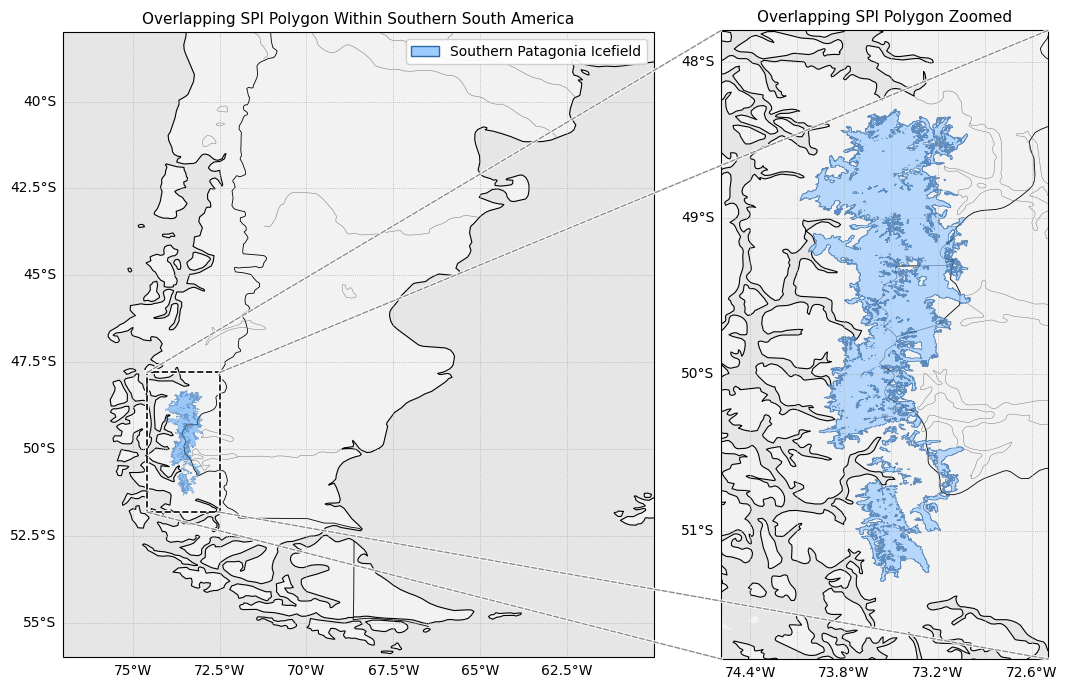

In [4]:
# Create zoomed and non-zoomed plots of SPI polygon
fig = plt.figure(figsize=(12, 7))
proj = ccrs.PlateCarree()
ax_over = plt.subplot(1, 2, 1, projection=proj)
ax_zoom = plt.subplot(1, 2, 2, projection=proj)

for ax, extent_map, title in [
    (ax_over, overview_extent, "Overlapping SPI Polygon Within Southern South America"),
    (ax_zoom,  zoom_extent, "Overlapping SPI Polygon Zoomed"),
]:
    ax.set_extent(extent_map, crs=proj)
    ax.add_feature(cfeature.LAND,  facecolor="0.95")
    ax.add_feature(cfeature.OCEAN, facecolor="0.90")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS,   linewidth=0.6)
    ax.add_feature(cfeature.LAKES, edgecolor="0.4", facecolor="none", linewidth=0.3)
    ax.add_feature(cfeature.RIVERS, edgecolor="0.5", linewidth=0.4)
    gl = ax.gridlines(draw_labels=True, linestyle=":", linewidth=0.6)
    gl.right_labels = gl.top_labels = False
    ax.set_title(title, fontsize=11)

# Polygon styles
poly_over = dict(facecolor="#419DFF", edgecolor="#3169A6", linewidth=0.2, alpha=0.5)
poly_zoom = dict(facecolor="#9DCCFF", edgecolor="#3169A6", linewidth=0.5, alpha=0.7)
ax_over.add_geometries([merged_wgs84], crs=proj, **poly_over)
ax_zoom.add_geometries([merged_wgs84], crs=proj, **poly_zoom)

plt.tight_layout()
fig.canvas.draw_idle()

# Dashed zoom rectangle on non-zoomed plot
zx0, zx1, zy0, zy1 = zoom_extent
zoom_rect = Rectangle((zx0, zy0), zx1 - zx0, zy1 - zy0,
                      fill=False, edgecolor="black", linewidth=1.2, linestyle="--",
                      transform=proj, zorder=20)
zoom_rect.set_path_effects([pe.Stroke(linewidth=3.0, foreground="white"), pe.Normal()])
ax_over.add_patch(zoom_rect)

# Connectors from non-zoomed figure to zoomed figure corners
corners_over = [(zx0, zy0), (zx1, zy0), (zx1, zy1), (zx0, zy1)]
corners_zoom_axes = [(0, 0), (1, 0), (1, 1), (0, 1)]
for (xA, yA), (xB, yB) in zip(corners_over, corners_zoom_axes):
    con = ConnectionPatch(
        xyA=(xA, yA), coordsA=ax_over.transData,
        xyB=(xB, yB), coordsB=ax_zoom.transAxes,
        axesA=ax_over, axesB=ax_zoom,
        color="gray", lw=1.0, ls="--", alpha=0.9, zorder=25,
    )
    con.set_path_effects([pe.Stroke(linewidth=2.4, foreground="white"), pe.Normal()])
    fig.add_artist(con)

# Add legend
poly_legend_handle = Patch(facecolor="#9DCCFF", edgecolor="#3169A6",
                           label="Southern Patagonia Icefield")
ax_over.legend(handles=[poly_legend_handle], loc="upper right", frameon=True, framealpha=0.9)

plt.tight_layout()

# Hide Download warnings for decluttering output
warnings.filterwarnings("ignore", category=DownloadWarning)
plt.show()

Notice a small section near the southern part of the SPI that appears missing. This gap represents areas where the two datasets didn’t perfectly overlap or where albedo values fell outside the valid [0, 1] range and were thus removed.

To visualize the datasets on the same grid, in the code below, I create two side-by-side plots showing albedo and elevation change across the SPI by using the same valid overlapping pixels.

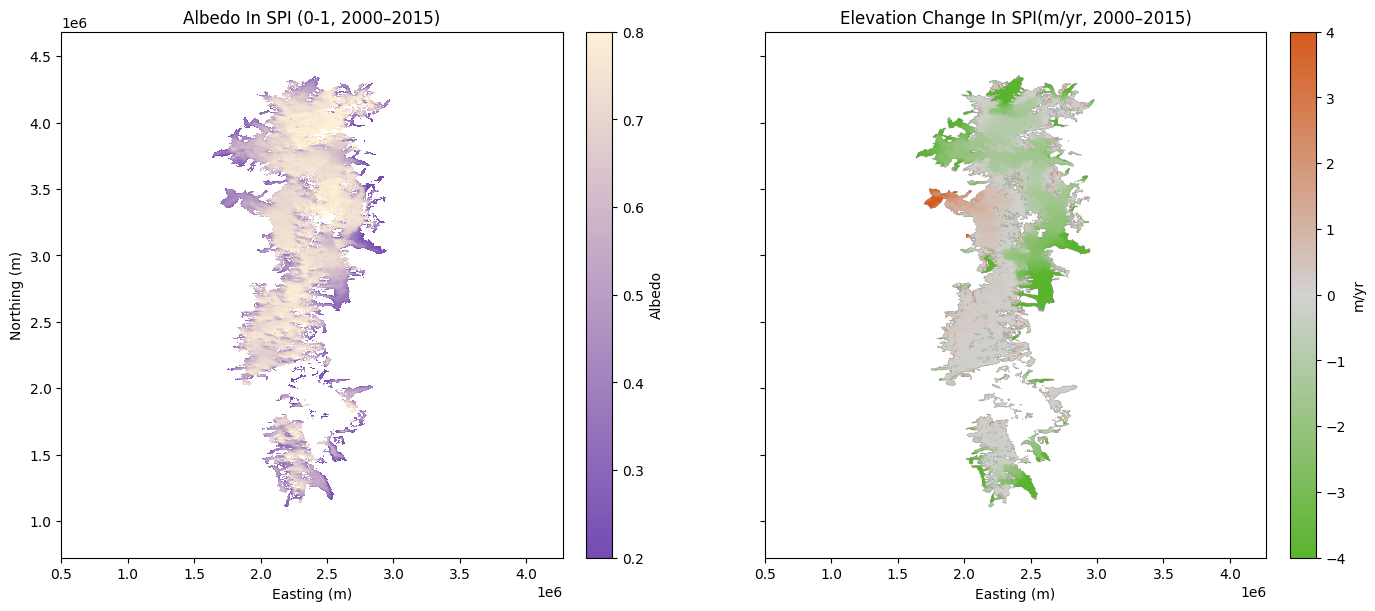

In [5]:
# Map borders on the elevation change grid
extent = array_bounds(thin.shape[0], thin.shape[1], transform)

# Overlap values
albedo_masked = np.where(overlap, albedo_on_thin, np.nan)
thin_masked = np.where(overlap, thin, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True, constrained_layout=True)

# Albedo color map
albedo_cmap = LinearSegmentedColormap.from_list(
    "albedo_twotone",
    ["#744BB3", "#FFF0D5"],
    N=256
).copy()
albedo_cmap.set_bad("#FFFFFF")

# Albedo plot
im1 = axes[0].imshow(
    albedo_masked,
    cmap=albedo_cmap,
    vmin=0.2, vmax=0.8,
    extent=extent, origin="upper",
    interpolation="nearest"
)
axes[0].set_title("Albedo In SPI (0-1, 2000–2015)")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
cbar1 = fig.colorbar(im1, ax=axes[0], label="Albedo", fraction=0.046, pad=0.04)

# Elevation change color map
cmap_div = LinearSegmentedColormap.from_list(
    "elev_white_zero",
    ["#5AB42D", "#D2D2D2", "#D65A1B"],
    N=256
).copy()
cmap_div.set_bad("none")

# Elevation change plot, grey-centered at 0
norm = TwoSlopeNorm(vmin=-4, vcenter=0.0, vmax=4)

# Elevation change plot
im2 = axes[1].imshow(
    thin_masked,
    cmap=cmap_div,
    norm=norm,
    extent=extent,
    origin="upper"
)
axes[1].set_title("Elevation Change In SPI(m/yr, 2000–2015)")
axes[1].set_xlabel("Easting (m)")
cbar2 = fig.colorbar(im2, ax=axes[1], label="m/yr", fraction=0.046, pad=0.04)

plt.show()

Lower reflectivity (smaller albedo) values are represented with a purple color on the left plot above, whereas cream color indicates higher reflectivity. Similarly, increased thinning (negative surface elevation change) values are green on the right plot above, whereas positive elevation change is reflected in red. Note that the grey color indicates areas with almost no average change in elevation over the 2000-2015 time period.

One of the limitations of the elevation change plot is that extreme values beyond the [-4, 4] range have the same green or red intensity as values at the interval borders.

Nevertheless, we see that SPI areas colored in purple and green somewhat overlap, hinting at the linear relationship between the variables discussed before.  

To better visualize the relationship, let's create a dataframe, count the number of valid overlapping pixels, and double check for missing values.

In [6]:
# Build DataFrame of overlapping pixel pairs
overl_pixels = pd.DataFrame({
    "albedo": albedo_on_thin[overlap],
    "el_change": thin[overlap]
})

# Pixel count, double-check missing values
print(f"Total overlapping pixels: {len(overl_pixels)}")
print("\nMissing value check:\n")
print(overl_pixels.isna().sum())

Total overlapping pixels: 11379250

Missing value check:

albedo       0
el_change    0
dtype: int64


From the code output above, we know there are 11,379,250 valid overlapping pixels, out of which none have missing albedo or elevation change values.

Below is a scatter plot visualization of the relationship between the variables.

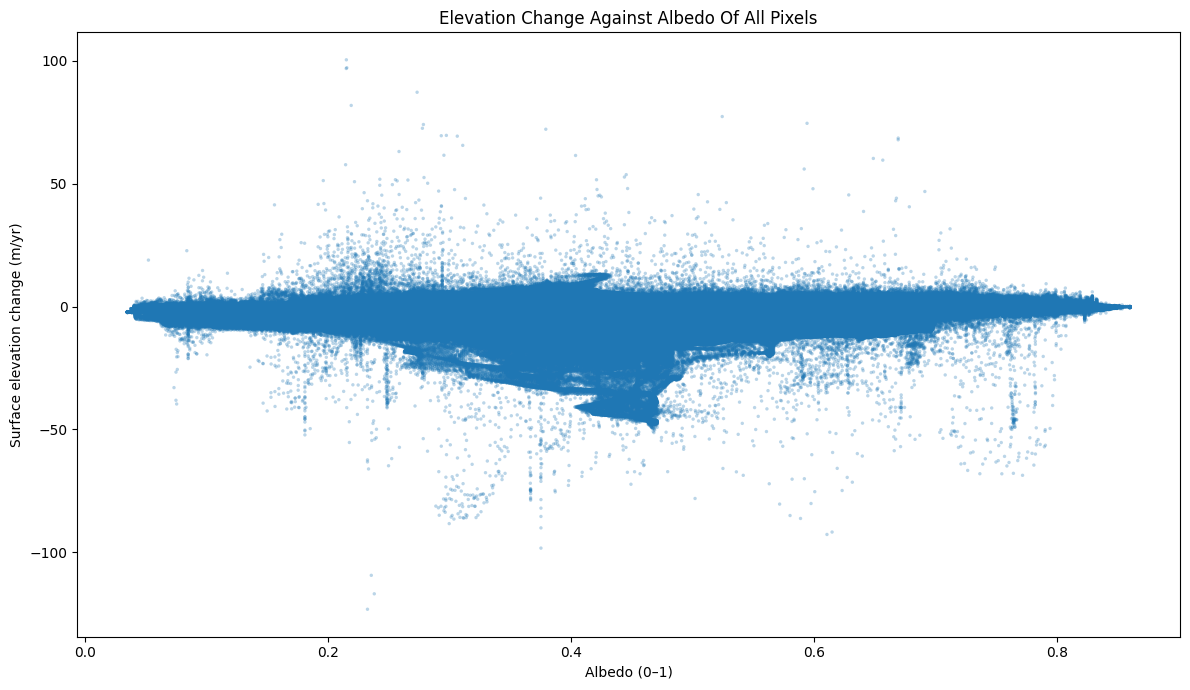

In [7]:
# Scatter plot between albedo and elevation change of all pixels
all_albedo = overl_pixels["albedo"].values
all_el_change = overl_pixels["el_change"].values

plt.figure(figsize=(12, 7))
plt.scatter(all_albedo, all_el_change, s=6, alpha=0.3, edgecolor="none")
plt.xlabel("Albedo (0–1)")
plt.ylabel("Surface elevation change (m/yr)")
plt.title("Elevation Change Against Albedo Of All Pixels")
plt.tight_layout()
plt.show()

Despite the scatter plot being very dense due to the high number of pixels, a significant number of datapoints seem to cluster near zero elevation change, with a wider spread when albedo reaches around 0.45, though overall the relationship seems somewhat linear.

Because the full dataset contains millions of pixels, I randomly select a subset of 5,000 datapoints to make model fitting faster, while preserving the overall distribution of variables.

In [8]:
# Sample 5000 datapoints for modelling
data = overl_pixels.sample(n=5000, random_state=31).reset_index(drop=True)

# Sampled datapoint count and fist 10 pixel variable values
print(f"Sampled {len(data)} pixels")
print("\nA couple of pixel values")
print(data.head(10))

Sampled 5000 pixels

A couple of pixel values
     albedo  el_change
0  0.541965  -0.379895
1  0.350052  -1.333267
2  0.703540  -0.401984
3  0.723332   0.314170
4  0.685152  -1.398861
5  0.715874   0.062428
6  0.705584  -1.811191
7  0.750786  -1.165435
8  0.695404   0.425837
9  0.752391  -0.810631


Next, I extract the albedo and elevation change values for all sampled pixels, storing them as X and Y for the modeling in the following sections. I then summarize the sample using the `arviz.summary()` function and visualize the relationship between the two variables to confirm that the subset represents the overall dataset pattern.

In [9]:
# Extract albedo and elevation change values and store as X and Y variables for data modelling
X = data["albedo"].values.astype(float)
Y = data["el_change"].values.astype(float)

# Short summary of the modelling data
az.summary({"albedo": X, "el_change": Y}, kind="stats")

mean     sd  hdi_3%  hdi_97%
albedo     0.621  0.150    0.32    0.823
el_change -1.136  2.872   -5.79    2.518

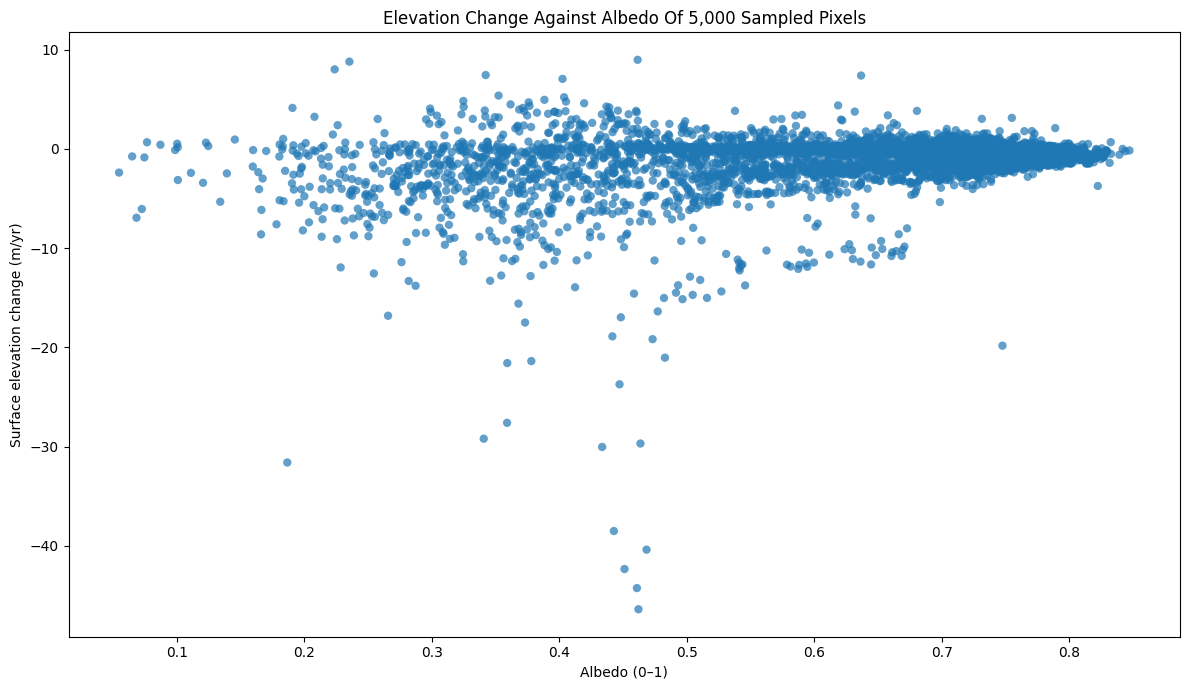

In [10]:
# Scatter plot between albedo and elevation change of modelling data
plt.figure(figsize=(12, 7))
plt.scatter(X, Y, alpha=0.7, edgecolor="none")
plt.xlabel("Albedo (0–1)")
plt.ylabel("Surface elevation change (m/yr)")
plt.title("Elevation Change Against Albedo Of 5,000 Sampled Pixels")
plt.tight_layout()
plt.show()

The scatter plot above shows 5,000 sampled pixels used for modeling, each representing a location within the SPI. Albedo is on the x-axis and average elevation change, measured in meters per year, is on the y-axis.

The visualization confirms that, after sampling, the general linear trend of the data has been preserved, with higher elevation change variation around albedo values of 0.45.

# Modelling

Before fitting any models, I first define several helper functions that make the modeling process more organized and consistent.

* `viz_model_graph()` uses PyMC’s built-in `model_to_graphviz()` to visualize a graphical representation of how parameters connect to observed data. It helps confirm that the model is built correctly before running any sampling, ensuring all relationships are defined.
* `viz_prior_params()` plots the prior distributions and their credible intervals using `ArviZ`’s visualization tools. It allows me to see whether the priors are too wide or too narrow, helping me adjust them before they bias the inference.
* `viz_prior_preview()` shows what the model “believes” before seeing any data. It plots multiple prior mean curves drawn from the priors, and overlays an 89% prior predictive band, helping me confirm that the priors make sense based on the data.
* `post_rank_plot()` helps check whether sampling worked correctly. It plots rank histograms to diagnose whether the Markov chains converged and mixed well.
* `post_samp_sum()` summarizes the posterior distributions of parameters, reporting statistics like the mean, standard deviation, and 89% credible intervals. I pay special attention to the `ess_bulk`, `ess_tail`, and `r_hat` values, which indicate how efficiently the sampler explores the posterior and whether the chains converged properly.
* `viz_post_params()` visualizes the posterior distributions of all parameters. It makes it easier to interpret their spread and uncertainty.
* `viz_post_fit_2panel()` produces a two-panel plot: one showing the full range of data and another zoomed in for detail. The red band represents the 95% credible interval of the fitted posterior curve, while the blue band shows the 95% predictive interval (the model’s uncertainty in predicting new data). Together, these intervals represent how confident the model is in its mean estimates and how much variability it expects in new observations.

The next code cell implements the functions described above.

In [11]:
def viz_model_graph(model):
    """Graphviz diagram for a PyMC model."""
    display(Image(pm.model_to_graphviz(model).render(format="png")))

def viz_prior_params(inf_data_prior, var_names, title="Prior parameter distributions"):
    """Histogram and HDI of prior parameters."""
    az.plot_posterior(inf_data_prior, group="prior", var_names=var_names, hdi_prob=0.89, kind="hist")
    plt.suptitle(title, y=1.02)
    plt.show()

# X-grid for following functions
XG = np.linspace(X.min(), X.max(), 200)

def viz_prior_preview(inf_data_prior, mu_grid_fn, sigma_grid_fn=None, x=X, y=Y, xg=XG, n_lines=300, seed=31, title="Prior mean functions (optional prior predictive)"):
    """
    Show multiple prior mean curves; if sigma_grid_fn is provided, adds 89% prior predictive band.
    """
    rng = np.random.default_rng(seed)
    mu_lines = mu_grid_fn(inf_data_prior, xg, group="prior")
    S = mu_lines.shape[0]
    idx = rng.choice(S, size=min(n_lines, S), replace=False)

    plt.figure(figsize=(7,5))
    plt.scatter(x, y, s=4, alpha=0.35, edgecolor="none", label="Data")
    plt.plot(xg, mu_lines[idx].T, color="0.5", alpha=0.07, lw=0.7)

    if sigma_grid_fn is not None:
        sig = sigma_grid_fn(inf_data_prior, xg, group="prior")
        take = min(300, S)
        jdx = rng.choice(S, size=take, replace=False)
        mu_sub  = mu_lines[jdx]
        sig_sub = sig[jdx]
        y_prior = mu_sub + rng.standard_normal(mu_sub.shape) * sig_sub
        pp_lo = np.quantile(y_prior, 0.055, axis=0)
        pp_hi = np.quantile(y_prior, 0.945, axis=0)
        plt.fill_between(xg, pp_lo, pp_hi, color="#3b82f6", alpha=0.18, label="89% prior predictive")

    plt.axhline(0, color="0.6", ls="--", lw=1)
    plt.xlabel("Albedo (0–1)")
    plt.ylabel("Surface elevation change (m/yr)")
    plt.title(title)
    plt.legend(frameon=False, loc="best")
    plt.tight_layout()
    plt.show()

def post_rank_plot(inf_data, var_names):
    """
    Visualize rank histogram
    """
    az.plot_rank(inf_data, var_names=var_names)
    plt.tight_layout(pad=1)
    plt.show()

def post_samp_sum(inf_data, var_names=None):
    """Posterior summary"""
    display(az.summary(inf_data, var_names=var_names))

def viz_post_params(inf_data, var_names, title="Posterior parameter distributions"):
    """
    Histogram and HDI of posterior parameters.
    """
    az.plot_posterior(inf_data, var_names=var_names, hdi_prob=0.89)
    plt.suptitle(title, y=1.02)
    plt.show()

def viz_post_fit_2panel(
    inf_data, mu_grid_fn, sigma_grid_fn=None,
    x=X, y=Y, xg=XG, zoom_ylim=(-5, 1), seed=31,
    label_prefix="Model"
):
    """
    Two-panel plot:
      left: full range of data and mean curve credible band + predictive band.
      right: zoomed y-limits
    """
    rng = np.random.default_rng(seed)
    # Credible band for mu(x)
    mu_samps = mu_grid_fn(inf_data, xg, group="posterior")
    mu_mean = mu_samps.mean(axis=0)
    mu_lo = np.quantile(mu_samps, 0.025, axis=0)
    mu_hi = np.quantile(mu_samps, 0.975, axis=0)

    # Predictive band from sigma(x)
    if sigma_grid_fn is not None:
        sig_samps = sigma_grid_fn(inf_data, xg, group="posterior")
    else:
        if hasattr(inf_data, "posterior_predictive") and "y_obs" in inf_data.posterior_predictive:
            y_pp = inf_data.posterior_predictive["y_obs"].values
            sig_samps = None
        else:
            sig_samps = None

    # If sigma(x) present, simulate predictive band
    pp_lo = pp_hi = None
    if sig_samps is not None:
        S = mu_samps.shape[0]
        take = min(1000, S)
        idx = rng.choice(S, size=take, replace=False)
        eps = rng.standard_normal(mu_samps[idx].shape) * sig_samps[idx]
        y_pred = mu_samps[idx] + eps
        pp_lo = np.quantile(y_pred, 0.025, axis=0)
        pp_hi = np.quantile(y_pred, 0.975, axis=0)

    # Plot full and zoomed ranges of data with the credible and predictive intervals
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True, constrained_layout=True)

    def draw(ax, zoom=False):
        ax.scatter(x, y, s=6, alpha=0.25, edgecolor="none", label="Observed pixels")
        if pp_lo is not None:
            ax.fill_between(xg, pp_lo, pp_hi, color="#3b82f6", alpha=0.18, label="95% Predictive Interval")
        ax.fill_between(xg, mu_lo, mu_hi, color="#ef4444", alpha=0.18, label="95% Credible Interval")
        ax.plot(xg, mu_mean, color="#ef4444", lw=1.3, label="Fitted Posterior Curve")
        ax.axhline(0, color="0.6", ls="--", lw=1)
        ax.set_xlabel("Albedo (0–1)")
        if ax is axes[0]:
            ax.set_ylabel("Surface elevation change (m/yr)")
        if zoom:
            ax.set_ylim(*zoom_ylim)
            ax.set_title(f"{label_prefix}: Zoomed y ∈ [{zoom_ylim[0]}, {zoom_ylim[1]}] m/yr")
        else:
            ax.set_title(f"{label_prefix}: Full Range")
        ax.legend(frameon=False, loc="best")

    draw(axes[0], zoom=False)
    draw(axes[1], zoom=True)
    plt.show()

## Homoscedastic Linear Model

### Setting Up The Model

To start, I build a simple Bayesian homoscedastic linear regression model that describes the relationship between albedo and surface elevation change across the SPI.

The main goal here is to create a baseline understanding of how glaciers' elevation changes as albedo increases.

In this model (and on par with the previous information), each pixel represents a paired observation $(x_i, y_i)$, where
* $x_i$ is the albedo value (unitless, ranging from 0 to 1),
* $y_i$ is the surface elevation change (in meters per year, positive for thickening, negative for thinning).

The model assumes that elevation change varies linearly with albedo and that deviations around the fitted line are normally distributed.

Formally, the model can be written as:

$$
y_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i=a + bx_i
$$

where
* $a$ is the intercept, representing the expected elevation change when albedo is zero,
* $b$ is the slope, describing how much elevation change shifts per unit increase in albedo,
* $\sigma$ is the standard deviation, representing variability in data.

The homoscedastic nature of the model encodes the assumption that the uncertainty ($\sigma$) is constant across all pixels (i.e., regardless of albedo value, the variability in elevation change remains roughly the same).
Although this is a simplification of the data (as the scatter plot for sampled pixels shows variability), it’s a good starting point before introducing more complex models later.

### Prior Choices

Before fitting the model, I define priors for each parameter to reflect weak but reasonable assumptions about the system:

$$
a \sim \text{Normal}(0, 10) \\
b \sim \text{Normal}(0, 10) \\
\sigma \sim \text{HalfNormal}(2)
$$

These priors represent the following beliefs:

* The intercept 𝑎 and slope 𝑏 are centered at zero, but wide enough (σ = 10) to allow both positive and negative relationships between the albedo and elevation change variables, because before seeing the data, we assume that it's unknown whether reflectivity leads to faster melting or slower melting, even though I learned in the *Earth's Cycles* class that the relationship is positive.
* The HalfNormal prior on $\sigma$ ensures that standard deviation is always positive and typically within a physically plausible range (most elevation changes are within ±5 m/yr).

### Model Implementation in `PyMC`

I implement the model in `PyMC`, following the same structure as the equations above.

Inside the with `pm.Model()` block, I:

* define the priors ($a$, $b$, $\sigma$).
* compute the linear predictor $\mu=a+bX$.
* model the observed data $Y$ as Normally distributed around $\mu$ with standard deviation $\sigma$.

I first use `pm.sample_prior_predictive()` to simulate prior expectations. Then, using `pm.sample()`, I draw posterior samples from the model given the observed SPI data, and finally run `pm.sample_posterior_predictive()` to generate predictions based on the posterior distributions.

In PyMC notation, the full model is defined as:

$$
a \sim \text{Normal}(0, 10) \\
b \sim \text{Normal}(0, 10) \\
\sigma \sim \text{HalfNormal}(2) \\
\mu_i = a+bx_i \\
y_i \sim \text{Normal}(\mu_i, \sigma)
$$



In [12]:
# Setting up and sampling homoscedastic linear model
with pm.Model() as linear:
    a = pm.Normal("a", mu=0.0, sigma=10)
    b = pm.Normal("b", mu=0.0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=2.0)
    mu = pm.Deterministic("mu", a + b * X)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    prior_linear = pm.sample_prior_predictive(samples=300, random_seed=31)
    post_linear = pm.sample(random_seed=31, chains=4, cores=2, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    post_pred_linear = pm.sample_posterior_predictive(post_linear, random_seed=31, extend_inferencedata=True)

Sampling: [a, b, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y_obs]


Output()

After sampling the model, there are no divergences in any of the sampler chains, which is good because it means that the sampler explored the posterior distribution smoothly, without getting stuck or missing regions, ensuring that the estimated parameter distributions for $a$, $b$, and $\sigma$ are reliable.

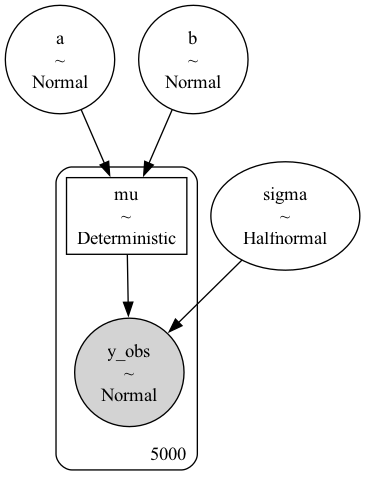

In [13]:
# Homoscedastic linear model diagram
viz_model_graph(linear)

After visualizing the model graph, we can confirm that the structure correctly represents the relationships defined in the homoscedastic linear model. The graph shows that both parameters $a$ and $b$ follow Normal priors and together determine $\mu$, the expected mean elevation change.

The residual variation around the mean is modeled through $\sigma$, drawn from a HalfNormal prior, as discussed above. The observed data $y_obs$ is modeled as Normally distributed around $\mu$ with standard deviation $\sigma$, capturing the assumption of constant (homoscedastic) noise across all albedo values.

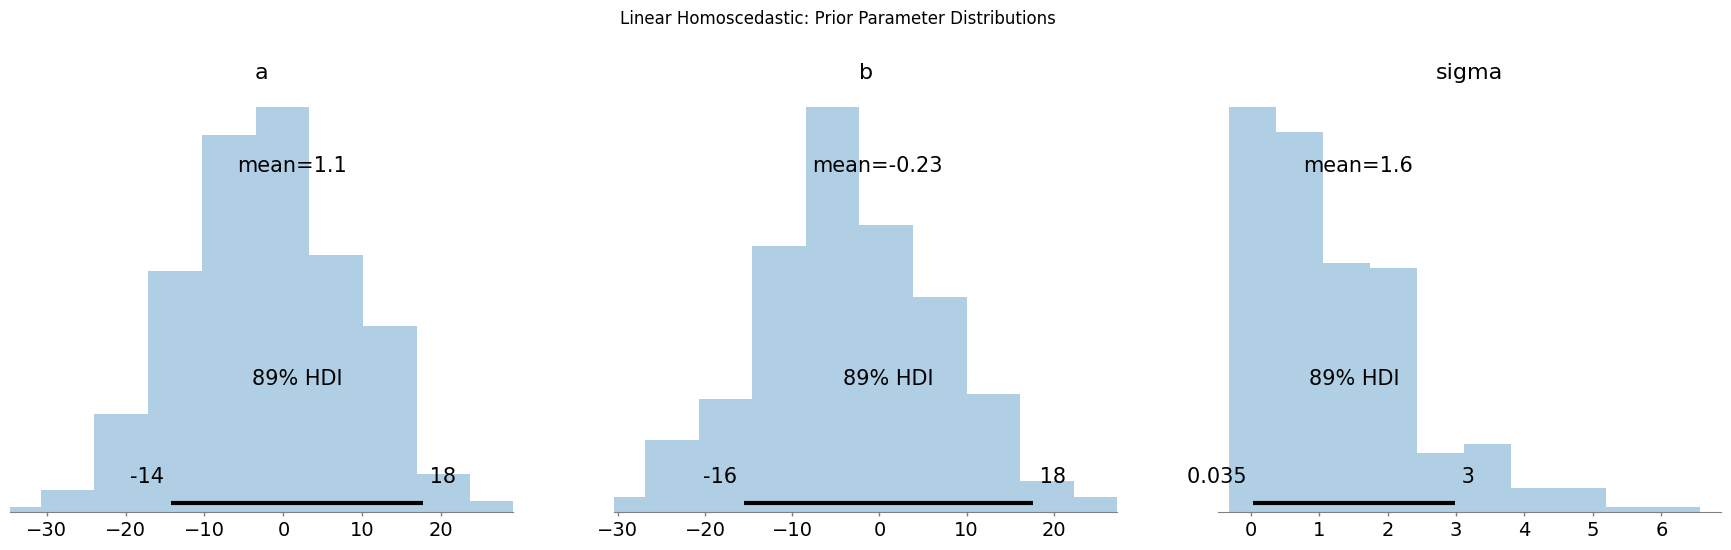

In [14]:
# Prior distributions of the linear homoscedastic model parameters
viz_prior_params(prior_linear, var_names=["a","b","sigma"], title="Linear Homoscedastic: Prior Parameter Distributions")

The visualization above shows that all prior parameters are weakly informative and centered around zero. Both $a$ (intercept) and $b$ (slope) follow broad Normal distributions, allowing the model to explore a wide range of possible linear relationships between albedo and elevation change. The prior for $\sigma$ ensures positive variability while keeping it within a realistic scale.

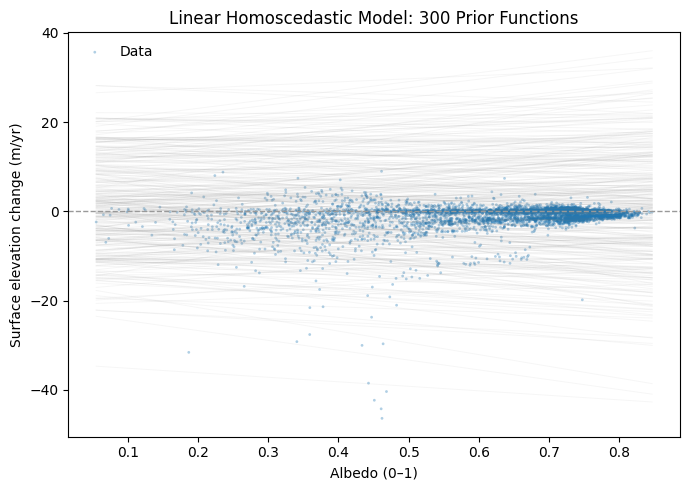

In [15]:
# Precompute prior draws as arrays
a_linear_prior = prior_linear.prior["a"].stack(sample=("chain","draw")).values[:, None]
b_linear_prior = prior_linear.prior["b"].stack(sample=("chain","draw")).values[:, None]

# Prior curves of linear homoscedastic model
viz_prior_preview(
    prior_linear,
    mu_grid_fn=lambda _idata, xg, group="prior": a_linear_prior + b_linear_prior * np.asarray(xg)[None, :],
    x=X, y=Y, xg=XG,
    n_lines=300,
    title="Linear Homoscedastic Model: 300 Prior Functions"
)

The prior predictive check above shows a wide range of possible lines, again reflecting weakly informative priors. This confirms that the model allows both positive and negative relationships between albedo and elevation change without imposing strong assumptions.

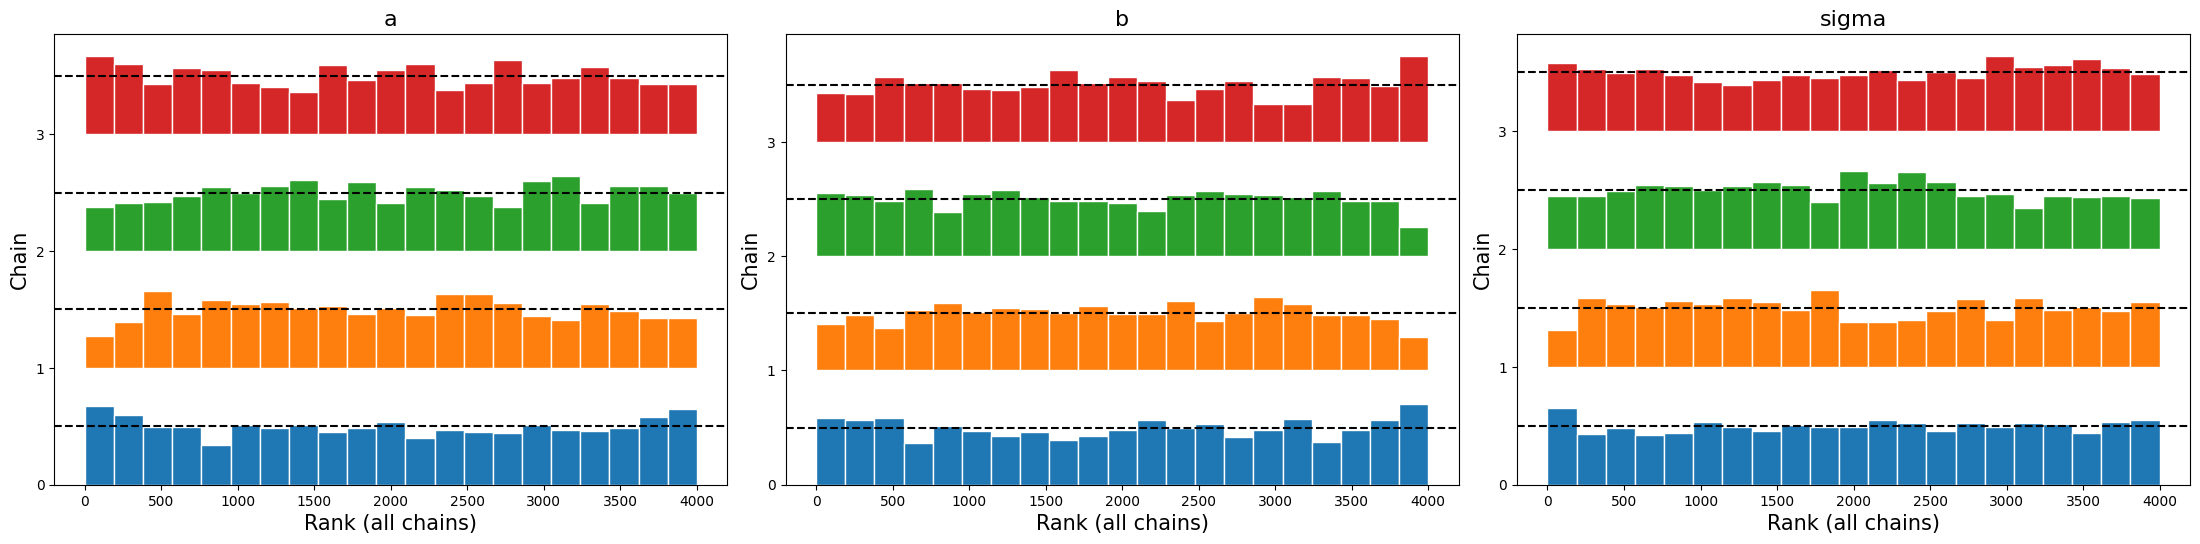

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -4.367  0.173  -4.682   -4.035      0.004    0.004    1668.0    1622.0   
b      5.200  0.270   4.672    5.692      0.007    0.006    1654.0    1453.0   
sigma  2.763  0.028   2.713    2.817      0.001    0.001    2076.0    1817.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

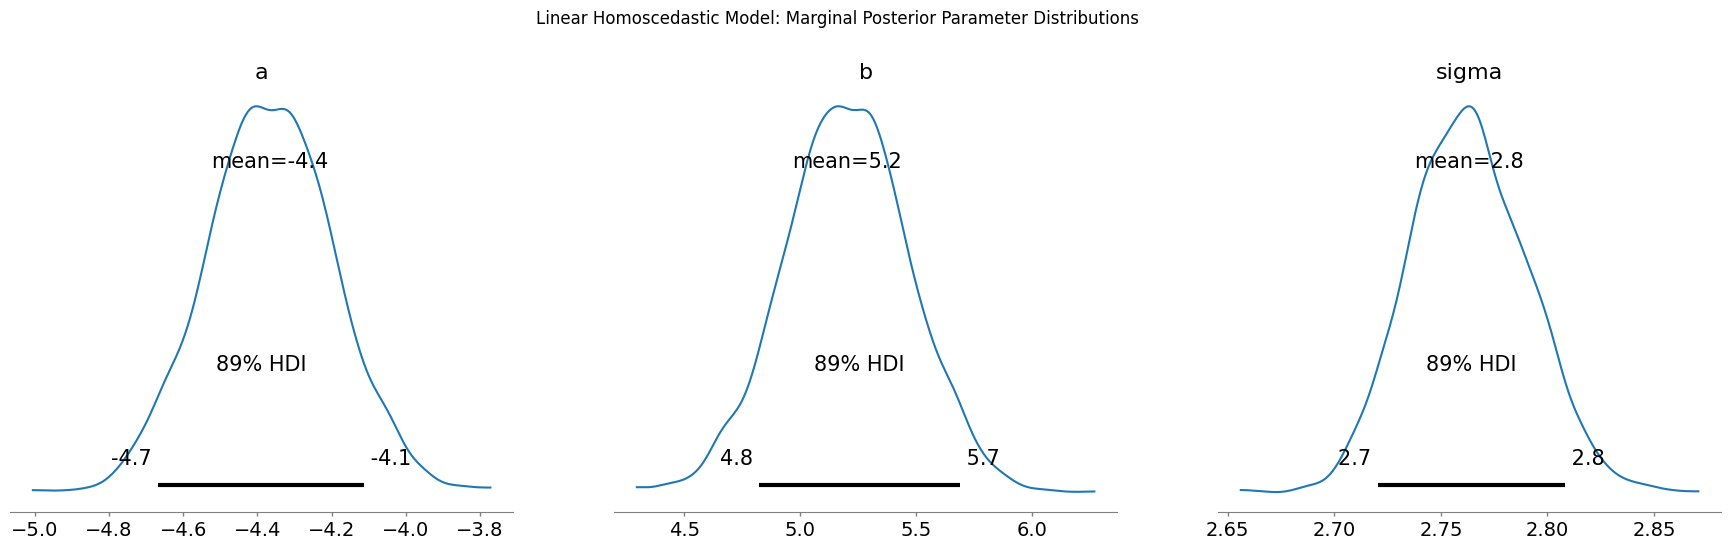

In [16]:
# Rank plot, summary, and marginal posterior parameter distribution of linear homoscedastic model
post_rank_plot(post_linear, var_names=["a","b","sigma"])
post_samp_sum(post_linear, var_names=["a","b","sigma"])
viz_post_params(post_linear, var_names=["a","b","sigma"], title="Linear Homoscedastic Model: Marginal Posterior Parameter Distributions")

The posterior sampling diagnostics above look good. The rank plots are fairly uniform, suggesting well-mixed chains. Both `ess_bulk` and `ess_tail` of all parameters are well above 10% of the total draws (more than 400), indicating efficient sampling, and all `r_hat` values are exactly 1.0, confirming full chain convergence. The posterior distributions are smooth and concentrated, showing stable estimates around $a \approx -4.65$, $b \approx 5.6$, and $\sigma \approx 2.87$, meaning the model found a consistent positive linear relationship with moderate uncertainty.

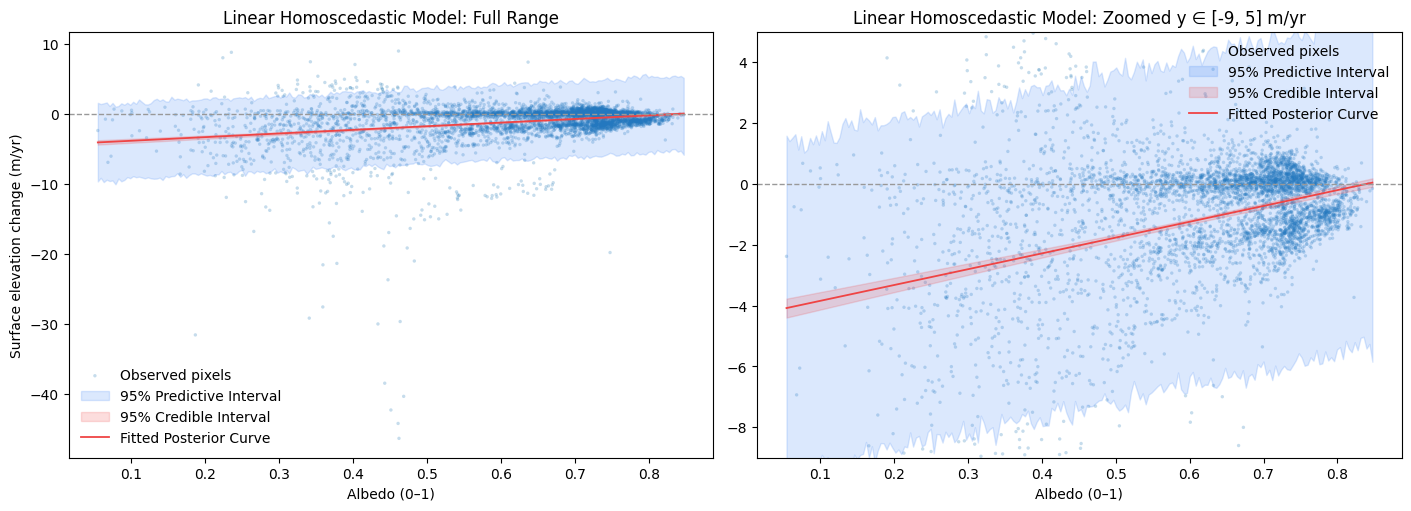

In [17]:
# Plot posterior predictive of linear homoscedastic model with the credible and predictive intervals
viz_post_fit_2panel(
    inf_data=post_pred_linear,
    mu_grid_fn=lambda idata, xg, group="posterior": (
        idata[group]["a"].stack(sample=("chain","draw")).values[:, None]
        + idata[group]["b"].stack(sample=("chain","draw")).values[:, None]
          * np.asarray(xg)[None, :]
    ),
    sigma_grid_fn=lambda idata, xg, group="posterior": np.repeat(
        idata[group]["sigma"].stack(sample=("chain","draw")).values[:, None],
        repeats=len(xg), axis=1
    ),
    x=X, y=Y, xg=XG,
    zoom_ylim=(-9, 5),
    seed=31,
    label_prefix="Linear Homoscedastic Model"
)

Based on the visualizations above, the model captures a clear positive relationship between albedo and elevation change, with higher albedo values generally associated with less thinning. The 95% credible interval widens a little at more variable albedo values, reflecting greater uncertainty where data is sparse. Overall, the fitted line captures the general trend between albedo and elevation change, but the 95% predictive interval indicates that the model struggles to represent extreme values, as many data points fall outside the predicted range.

So let's define another model that accounts for the variation in data more effectively.

## Heteroscedastic Linear

### Setting Up The Model

Similarly to the homoscedastic model, this heteroscedastic linear regression describes the relationship between albedo and surface elevation change. However, unlike the previous model, it allows the variability of elevation change to change with albedo; it removes the assumption that the noise around the regression line is constant.

I motivate this assumption by the data itself, as the sampled scatter plot of elevation change versus albedo at the beginning of the report shows that variability increases for lower albedo values and tends to shrink for higher ones. The heteroscedastic model captures this by making the standard deviation, $\sigma$, a function of albedo.

Formally, the model is expressed as:

$$
y_i \sim \text{Normal}(\mu_i, \sigma_i) \\
\mu_i = a+bx_i \\
\text{log}(\sigma_i) = c_0+c_1x_i
$$

where
* $a$ and $b$ define the mean relationship, just like in the homoscedastic model.
* $c_0$ is the baseline log-variance term.
* $c_1$ captures how the variability (on the log scale) changes as albedo increases.

Exponentiating the log-scale expression ensures $\sigma_i$ is always positive, and allows the uncertainty to change across albedo values.

### Prior Choices

The prior structure is similar to the homoscedastic model for the mean parameters ($a$, $b$) but brings in new priors for the variance parameters:


$$
a \sim \text{Normal}(0, 10) \\
b \sim \text{Normal}(0, 10) \\
c_0 \sim \text{Normal}(0, 3) \\
c_1 \sim \text{Normal}(0, 3) \\
$$

These priors encode the belief that while the overall relationship between albedo and elevation change could be positive or negative, the variability in elevation change may still change meaningfully across albedo values. The wider priors for $c_0$ and $c_1$, set as $\text{Normal}(0, 3)$ allow the model to flexibly represent a broader range of heteroscedastic patterns, so the model remains weakly informative but is better equipped to capture strong variance.


In [18]:
# Setting up and sampling heteroscedastic linear model
with pm.Model() as het_linear:
    a  = pm.Normal("a",  mu=0.0, sigma=10.0)
    b  = pm.Normal("b",  mu=0.0, sigma=10.0)
    c0 = pm.Normal("c0", mu=0.0, sigma=3.0)
    c1 = pm.Normal("c1", mu=0.0, sigma=3.0)
    mu = pm.Deterministic("mu", a + b * X)
    log_sigma = pm.Deterministic("log_sigma", c0 + c1 * X)
    sigma_x = pm.Deterministic("sigma_x", pm.math.exp(log_sigma))
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_x, observed=Y)

    prior_het_linear = pm.sample_prior_predictive(samples=300, random_seed=31, return_inferencedata=True)
    post_het_linear = pm.sample(random_seed=31, chains=4, cores=2, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
    post_pred_het_linear = pm.sample_posterior_predictive(post_het_linear, random_seed=31, extend_inferencedata=True)

Sampling: [a, b, c0, c1, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b, c0, c1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [y_obs]


Output()

After sampling the model, there are, again, no divergences in any of the sampler chains, meaning that the sampler is not getting stuck or missing regions while walking over the posterior parameter space.

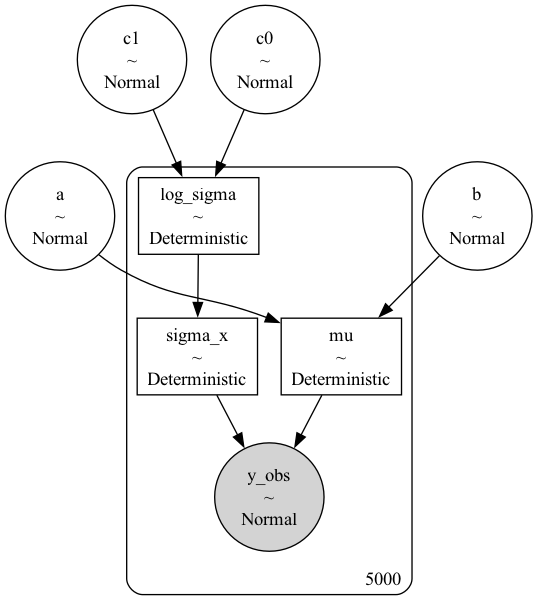

In [19]:
# Heteroscedastic linear model diagram
viz_model_graph(het_linear)

After visualizing the model graph, we can confirm that the structure correctly represents the relationships in the heteroscedastic linear model.
Similar to the homoscedastic case, parameters $a$ and $b$ determine the mean $\mu$, but now two additional parameters, $c_0$ and $c_1$, control how variability changes with albedo through $\text{log} (\sigma)=c_0+c_1X$.

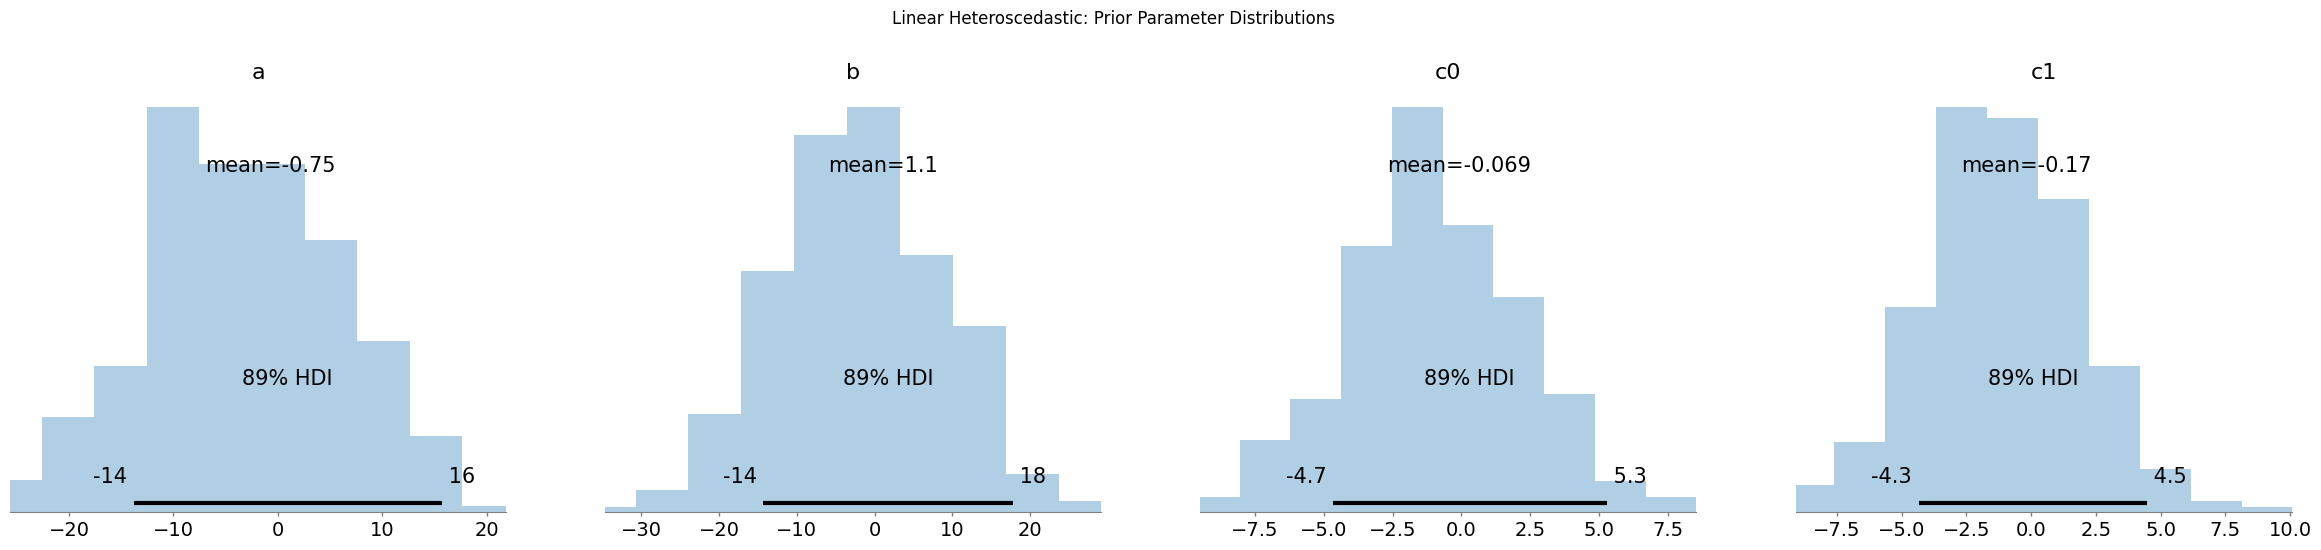

In [20]:
# Prior distributions of the linear heteroscedastic model parameters
viz_prior_params(prior_het_linear, var_names=["a", "b", "c0", "c1"], title="Linear Heteroscedastic: Prior Parameter Distributions")

The prior parameter distributions above show broad, weakly informative priors for all four parameters. Similar to the homoscedastic model, $a$ and $b$ remain centered near zero, allowing both positive and negative linear trends. The new parameters $c_0$ and $c_1$ also have reasonably wide Normal priors, leaving enough flexibility for the data to determine whether variance increases or decreases across albedo values.

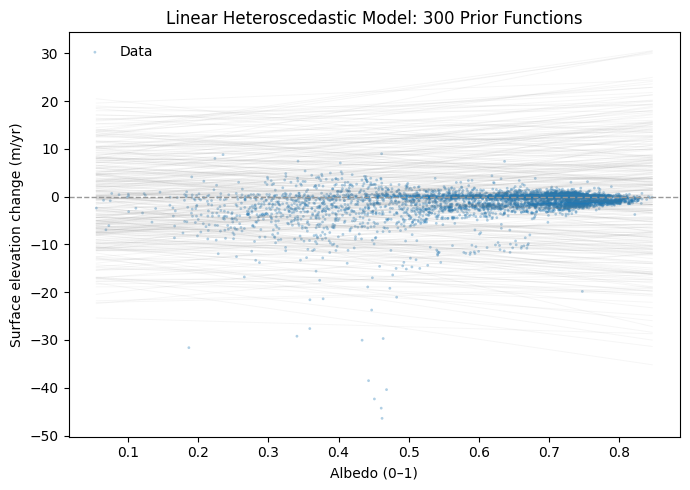

In [21]:
# Precompute prior draws as arrays
mu_prior_grid_het_linear = lambda inf_data, xg, group="prior": (
    inf_data[group]["a"].stack(sample=("chain","draw")).values[:, None]
    + inf_data[group]["b"].stack(sample=("chain","draw")).values[:, None] * np.asarray(xg)[None, :]
)

# Prior curves of linear heteroscedastic model
viz_prior_preview(
    prior_het_linear,
    mu_grid_fn=mu_prior_grid_het_linear,
    x=X, y=Y, xg=XG,
    n_lines=300,
    title="Linear Heteroscedastic Model: 300 Prior Functions"
)

The prior predictive check for the heteroscedastic model again shows a wide range of possible mean functions, reflecting weakly informative priors.

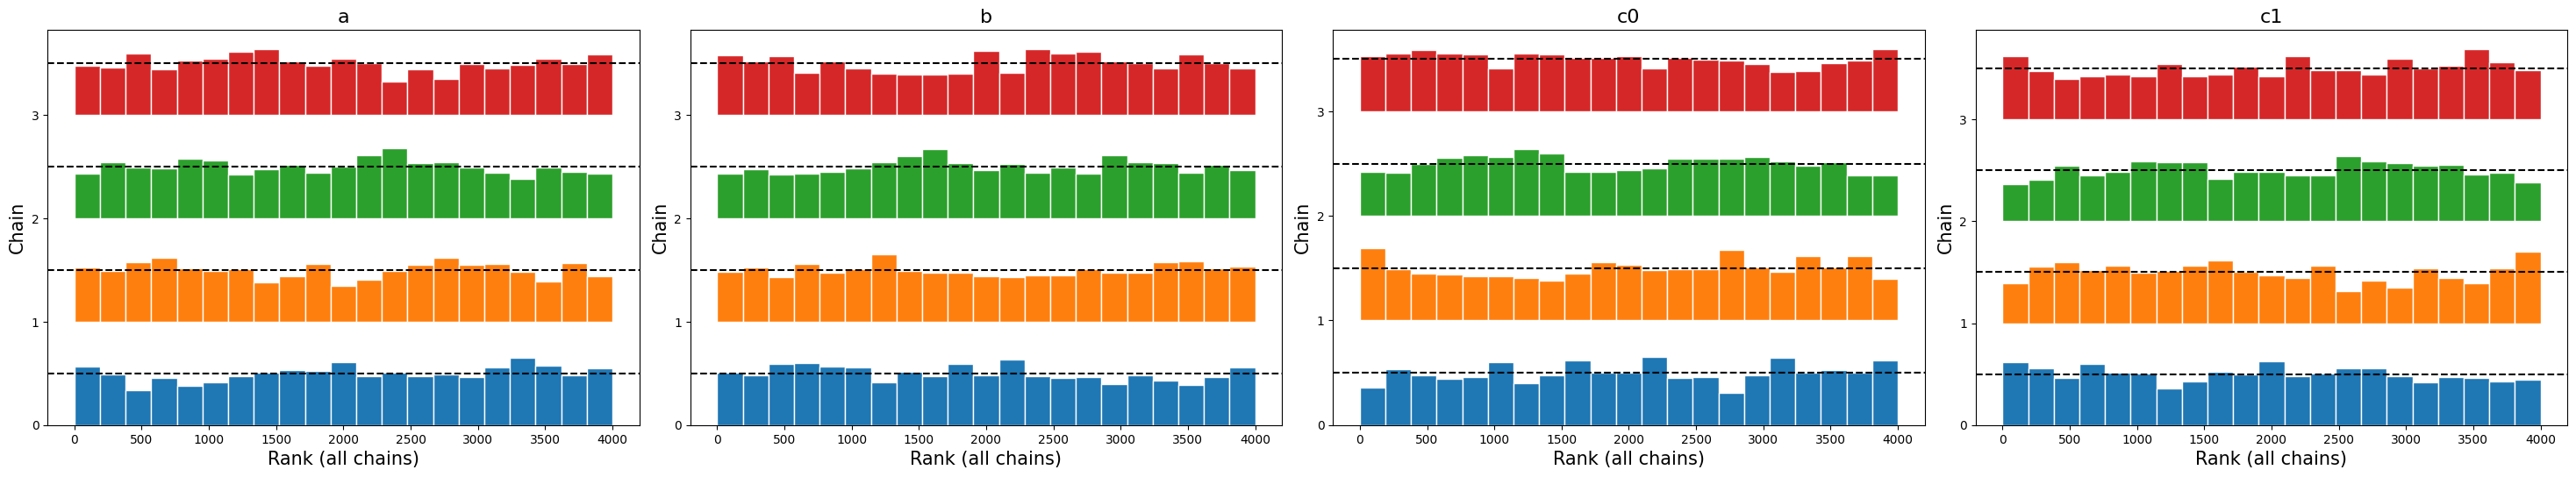

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  -2.994  0.220  -3.408   -2.580      0.006    0.004    1444.0    1449.0   
b   3.241  0.302   2.695    3.831      0.008    0.006    1441.0    1450.0   
c0  3.514  0.050   3.421    3.605      0.001    0.001    1549.0    1313.0   
c1 -4.590  0.080  -4.741   -4.449      0.002    0.002    1569.0    1311.0   

    r_hat  
a     1.0  
b     1.0  
c0    1.0  
c1    1.0

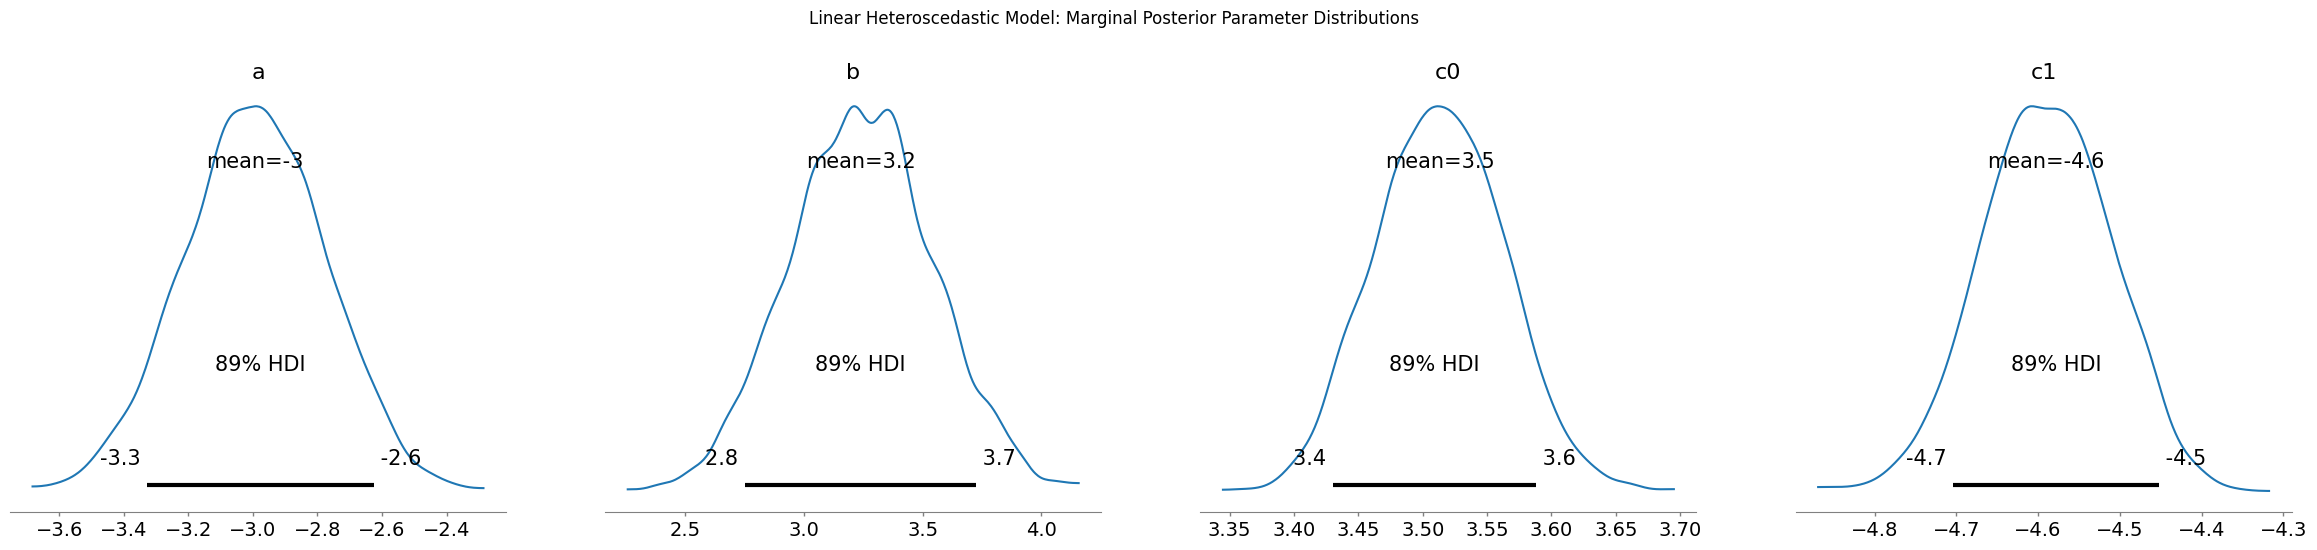

In [22]:
# Rank plot, summary, and marginal posterior parameter distribution of linear heteroscedastic model
post_rank_plot(post_het_linear, var_names=["a", "b", "c0", "c1"])
post_samp_sum(post_het_linear, var_names=["a", "b", "c0", "c1"])
viz_post_params(post_het_linear, var_names=["a", "b", "c0", "c1"], title="Linear Heteroscedastic Model: Marginal Posterior Parameter Distributions")

The posterior diagnostics again indicate a well-behaved model. The rank plots are uniform, with all r_hat values equal to 1.0, confirming chain convergence. Both `ess_bulk` and `ess_tail` exceed 400 for all parameters, suggesting efficient sampling. The posteriors are smooth and stable around $a \approx -2.98$, $b \approx 3.22$, $c_0 \approx 3.52$, and $c_1 \approx -4.59$, showing a positive mean trend and a clear decrease in variance as albedo increases, consistent with the heteroscedastic assumption.

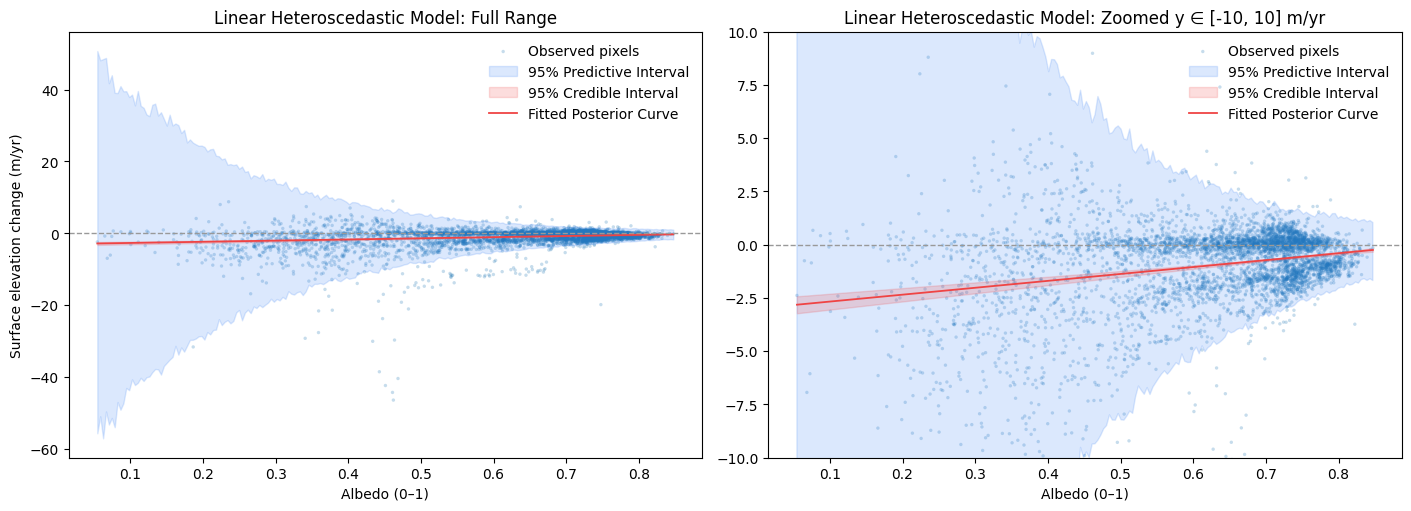

In [23]:
# Plot posterior predictive of linear heteroscedastic model with the credible and predictive intervals
mu_post_grid_het_linear = lambda inf_data, xg, group="posterior": (
    inf_data[group]["a"].stack(sample=("chain","draw")).values[:, None]
    + inf_data[group]["b"].stack(sample=("chain","draw")).values[:, None] * np.asarray(xg)[None, :]
)

sigma_post_grid_het_linear = lambda inf_data, xg, group="posterior": np.exp(
    inf_data[group]["c0"].stack(sample=("chain","draw")).values[:, None]
    + inf_data[group]["c1"].stack(sample=("chain","draw")).values[:, None] * np.asarray(xg)[None, :]
)

viz_post_fit_2panel(
    inf_data=post_pred_het_linear,
    mu_grid_fn=mu_post_grid_het_linear,
    sigma_grid_fn=sigma_post_grid_het_linear,
    x=X, y=Y, xg=XG,
    zoom_ylim=(-10, 10),
    label_prefix="Linear Heteroscedastic Model"
)

Based on the visualizations above, the heteroscedastic model better reflects the changing variance in elevation change across albedo values. The predictive intervals are much wider at lower albedo and narrow as albedo increases, consistent with the data’s pattern of higher variability in low-albedo regions and lower variability in high-albedo ones. This demonstrates that the model successfully captures non-constant noise, offering a more realistic fit than the homoscedastic model while preserving the same overall positive trend.

Let's try another model that can capture potential nonlinearity in the relationship between albedo and elevation change, using B-splines to allow the fitted curve to adapt to variations in the data.

## B-Splines

Before constructing the B-spline models, I first define helper functions that generate and center the spline basis matrices used to represent nonlinear relationships.

* `quantile_knots()` determines knot locations based on quantiles of the predictor variable, ensuring that knots are placed more densely where data points are concentrated.
* `bs_from_knots()` creates a B-spline design matrix given those knots, using cubic (degree = 3) splines to provide smooth, flexible curves.
* `centered_bs()` standardizes the spline bases by centering them, which improves model stability by removing bias in the mean prediction.

In [24]:
def quantile_knots(x_vals, num_knots):
    """Knot locations at equally spaced quantiles."""
    qs = np.linspace(0, 1, num_knots + 2)[1:-1]
    knots = np.quantile(x_vals, qs)
    return np.unique(knots)

def bs_from_knots(x_vals, knots, degree=3):
    """B-spline design matrix using explicit interior knots."""
    return np.asarray(
        dmatrix(
            f"bs(x, knots=knots, degree={degree}, include_intercept=False)",
            {"x": x_vals, "knots": knots},
        ),
        order="F",
    )

def centered_bs(x_fit, x_grid, num_knots, degree=3):
    """
    Builds B-spline designs with density-based knots.
    """
    knots = quantile_knots(x_fit, num_knots)
    B_fit  = bs_from_knots(x_fit,  knots, degree=degree)
    col_means = B_fit.mean(axis=0, keepdims=True)
    B_fit_c = B_fit - col_means

    B_grid = bs_from_knots(x_grid, knots, degree=degree)
    B_grid_c = B_grid - col_means
    return B_fit_c, B_grid_c

### Setting Up The B-Spline Model

While the previous models captured constant or smoothly varying noise, they still constrained the relationship between albedo and elevation change to be a straight line. However, in the real world, the glacier thinning might not change linearly with reflectivity; the relationship could flatten, steepen, or reverse in certain albedo ranges, which is hard to tell from the sampled pixels scatter plot.

To account for this, I build a Bayesian spline regression model, where the mean elevation change is modeled as a smooth, flexible curve composed of cubic B-splines.

The spline model thus expresses elevation change as a weighted sum of basis functions rather than a single slope:

$$
y_i \sim \text{Normal}(\mu_i, \sigma_i) \\
\mu_i = a+\sum\limits_{j=1}^Kw_{m,j}B_{m,j}(x_i)
$$

where

* $a$ is the intercept,
* $B_{m,j}(x_i)$ are the B-spline basis functions for albedo,
* $w_{m,j}$ are their corresponding weights, and
* $\sigma_i$ is allowed to vary across $x_i$, similar to the heteroscedastic model.

The heteroscedastic component is again modeled on the log scale to ensure positivity:

$$
\text{log}(\sigma_i)=c_0+\sum\limits_{j=1}^Lw_{s,j}B_{s,j}(x_i) \\
\sigma_i=\text{exp}(\text{log}(\sigma_i))
$$

where $B_{s,j}(x_i)$ are smoother spline bases that describe how the uncertainty changes with albedo.

### Prior Choices

The priors are chosen to be weakly informative yet stable:

$$
a \sim \text{Normal}(0, 100) \\
w_m \sim \text{Normal}(0, 100) \\
c_0 \sim \text{Normal}(0, 0.5) \\
w_s \sim \text{Normal}(0, 0.5)
$$

These priors reflect the belief that while the overall relationship between albedo and elevation change could take many shapes (through the spline weights), the variations in mean and noise should remain within realistic ranges. The smaller scale for $c_0$ and $w_s$ regularizes the variability component, preventing the model from overfitting noisy fluctuations in the data.

I now set up and sample three B-spline models with 3, 5, and 7 knots, storing the sampling outputs globally for future visualizations.

In [25]:
# Setting up and sampling spline models with 3, 5, and 7 knots
for k in (3, 5, 7):
    # Build mean/sd bases
    Bm, Bm_g = centered_bs(X, XG, num_knots=k)
    Bs, Bs_g = centered_bs(X, XG, num_knots=3)

    with pm.Model() as m:
        a   = pm.Normal("a", 0, 100)
        w_m = pm.Normal("w_m", 0, 100, shape=Bm.shape[1])
        mu  = pm.Deterministic("mu", a + pm.math.dot(Bm, w_m))
        c0  = pm.Normal("c0", 0, 0.5)
        w_s = pm.Normal("w_s", 0, 0.5, shape=Bs.shape[1])
        log_sigma = pm.Deterministic("log_sigma", c0 + pm.math.dot(Bs, w_s))
        sigma_x = pm.Deterministic("sigma_x", pm.math.exp(log_sigma))
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma_x, observed=Y)

        prior = pm.sample_prior_predictive(samples=300, random_seed=31, return_inferencedata=True)
        post = pm.sample(random_seed=31, chains=4, cores=1, return_inferencedata=True, idata_kwargs={"log_likelihood": True})
        post_pred = pm.sample_posterior_predictive(post, random_seed=31, extend_inferencedata=True)

    # Store variables globally
    globals()[f"spline_{k}"] = m
    globals()[f"prior_spline_{k}"] = prior
    globals()[f"post_spline_{k}"] = post
    globals()[f"post_pred_spline_{k}"] = post_pred

Sampling: [a, c0, w_m, w_s, y_obs]
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, w_m, c0, w_s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [y_obs]


Output()

Sampling: [a, c0, w_m, w_s, y_obs]
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, w_m, c0, w_s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
Sampling: [y_obs]


Output()

Sampling: [a, c0, w_m, w_s, y_obs]
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a, w_m, c0, w_s]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
Sampling: [y_obs]


Output()

After sampling the models, there are again no divergences in any of the sampler chains, meaning that the samplers did not get stuck or miss any regions while going over the posterior parameter space.

Spline 3 Model


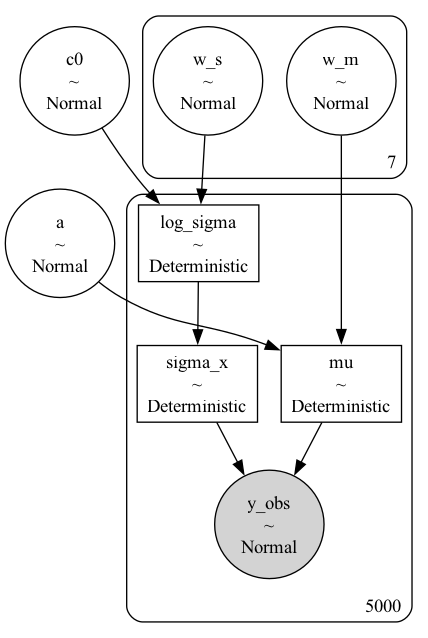

Spline 5 Model


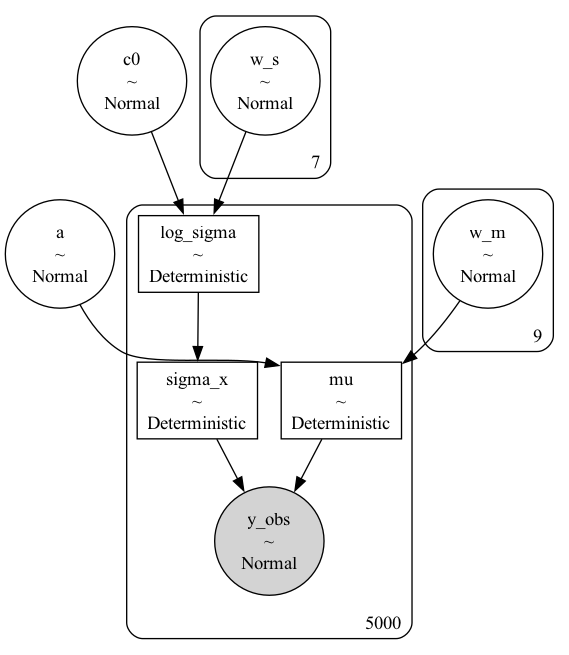

Spline 7 Model


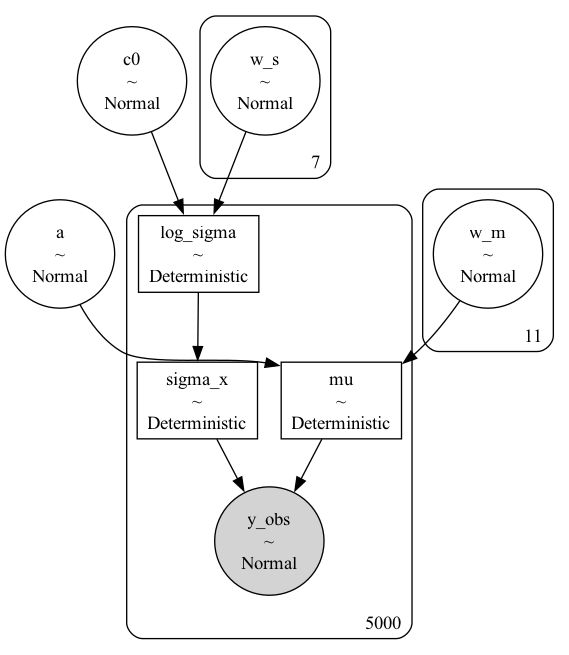

In [26]:
# B-spline with 3, 5, and 7 model diagrams
for k in (3, 5, 7):
    print(f"Spline {k} Model")
    viz_model_graph(globals()[f"spline_{k}"])

After visualizing the model graphs for the spline models with 3, 5, and 7 knots, we can confirm that they correctly represent the structure of the B-spline formulation.

Each diagram shows how the intercept ($a$) and the spline weights ($w_m$) together determine the mean $\mu$, while the variance is modeled through the parameters $c_0$ and $w_s$, defining $\log(\sigma_x)$ and its exponential transformation $\sigma_x$.

Compared to the previous homoscedastic and heteroscedastic linear models, these graphs reveal a richer structure; the mean and variance are now both flexible functions of albedo, allowing the model to capture nonlinear trends and varying uncertainty across the data range.

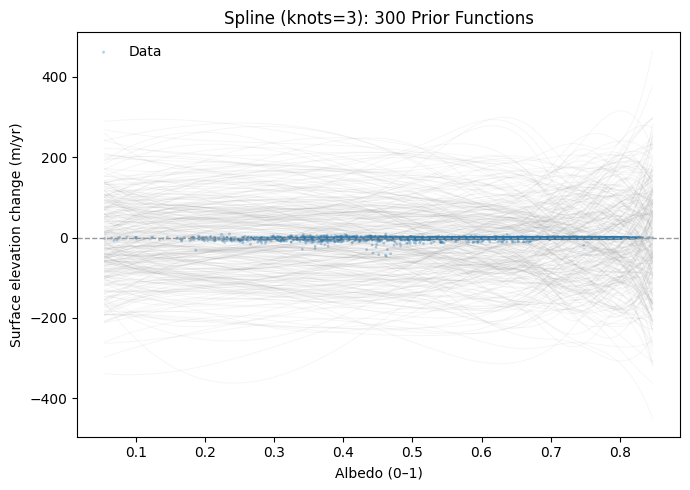

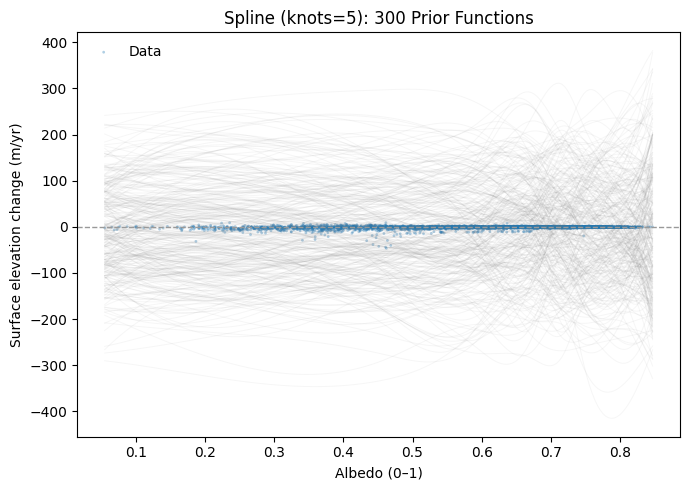

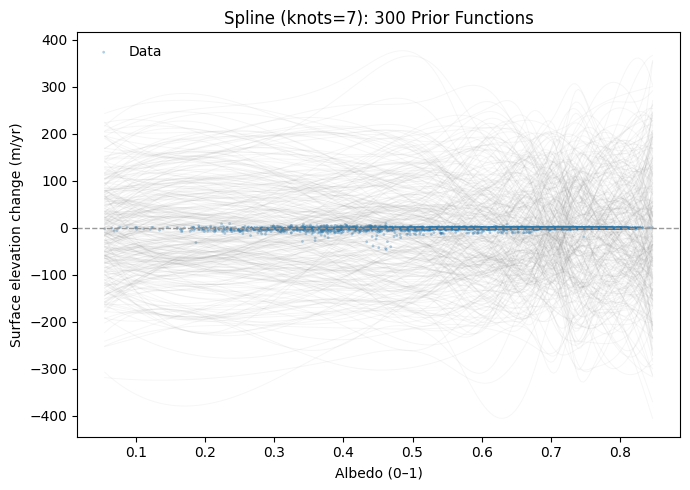

In [27]:
# Prior mean curves of linear heteroscedastic model
for k in (3, 5, 7):
    # Rebuild centered B-spline bases for each k
    Bm, Bm_g = centered_bs(X, XG, num_knots=k)
    Bs, Bs_g = centered_bs(X, XG, num_knots=3)

    prior = globals().get(f"prior_spline_{k}")

    def mu_prior_grid_spline(idata, xg, group="prior", Bm_g=Bm_g):
        a = idata[group]["a"].stack(sample=("chain","draw")).values[:, None]

        wm = idata[group]["w_m"].stack(sample=("chain","draw"))
        kdim = [d for d in wm.dims if d not in ("chain","draw","sample")][0]
        if wm.dims[0] != "sample":
            wm = wm.transpose("sample", kdim)
        else:
            wm = wm.transpose("sample", kdim)
        wm = wm.values

        return a + wm @ Bm_g.T

    viz_prior_preview(
        prior,
        mu_grid_fn=mu_prior_grid_spline,
        x=X, y=Y, xg=XG,
        n_lines=300,
        title=f"Spline (knots={k}): 300 Prior Functions"
    )

The prior predictive checks for the spline models with 3, 5, and 7 knots show a broad range of possible functions, consistent with weakly informative priors.

Unlike the linear models, these priors allow the mean to bend and curve, illustrating how increasing the number of knots adds flexibility to capture nonlinear relationships between albedo and elevation change.

Spline 3 Model


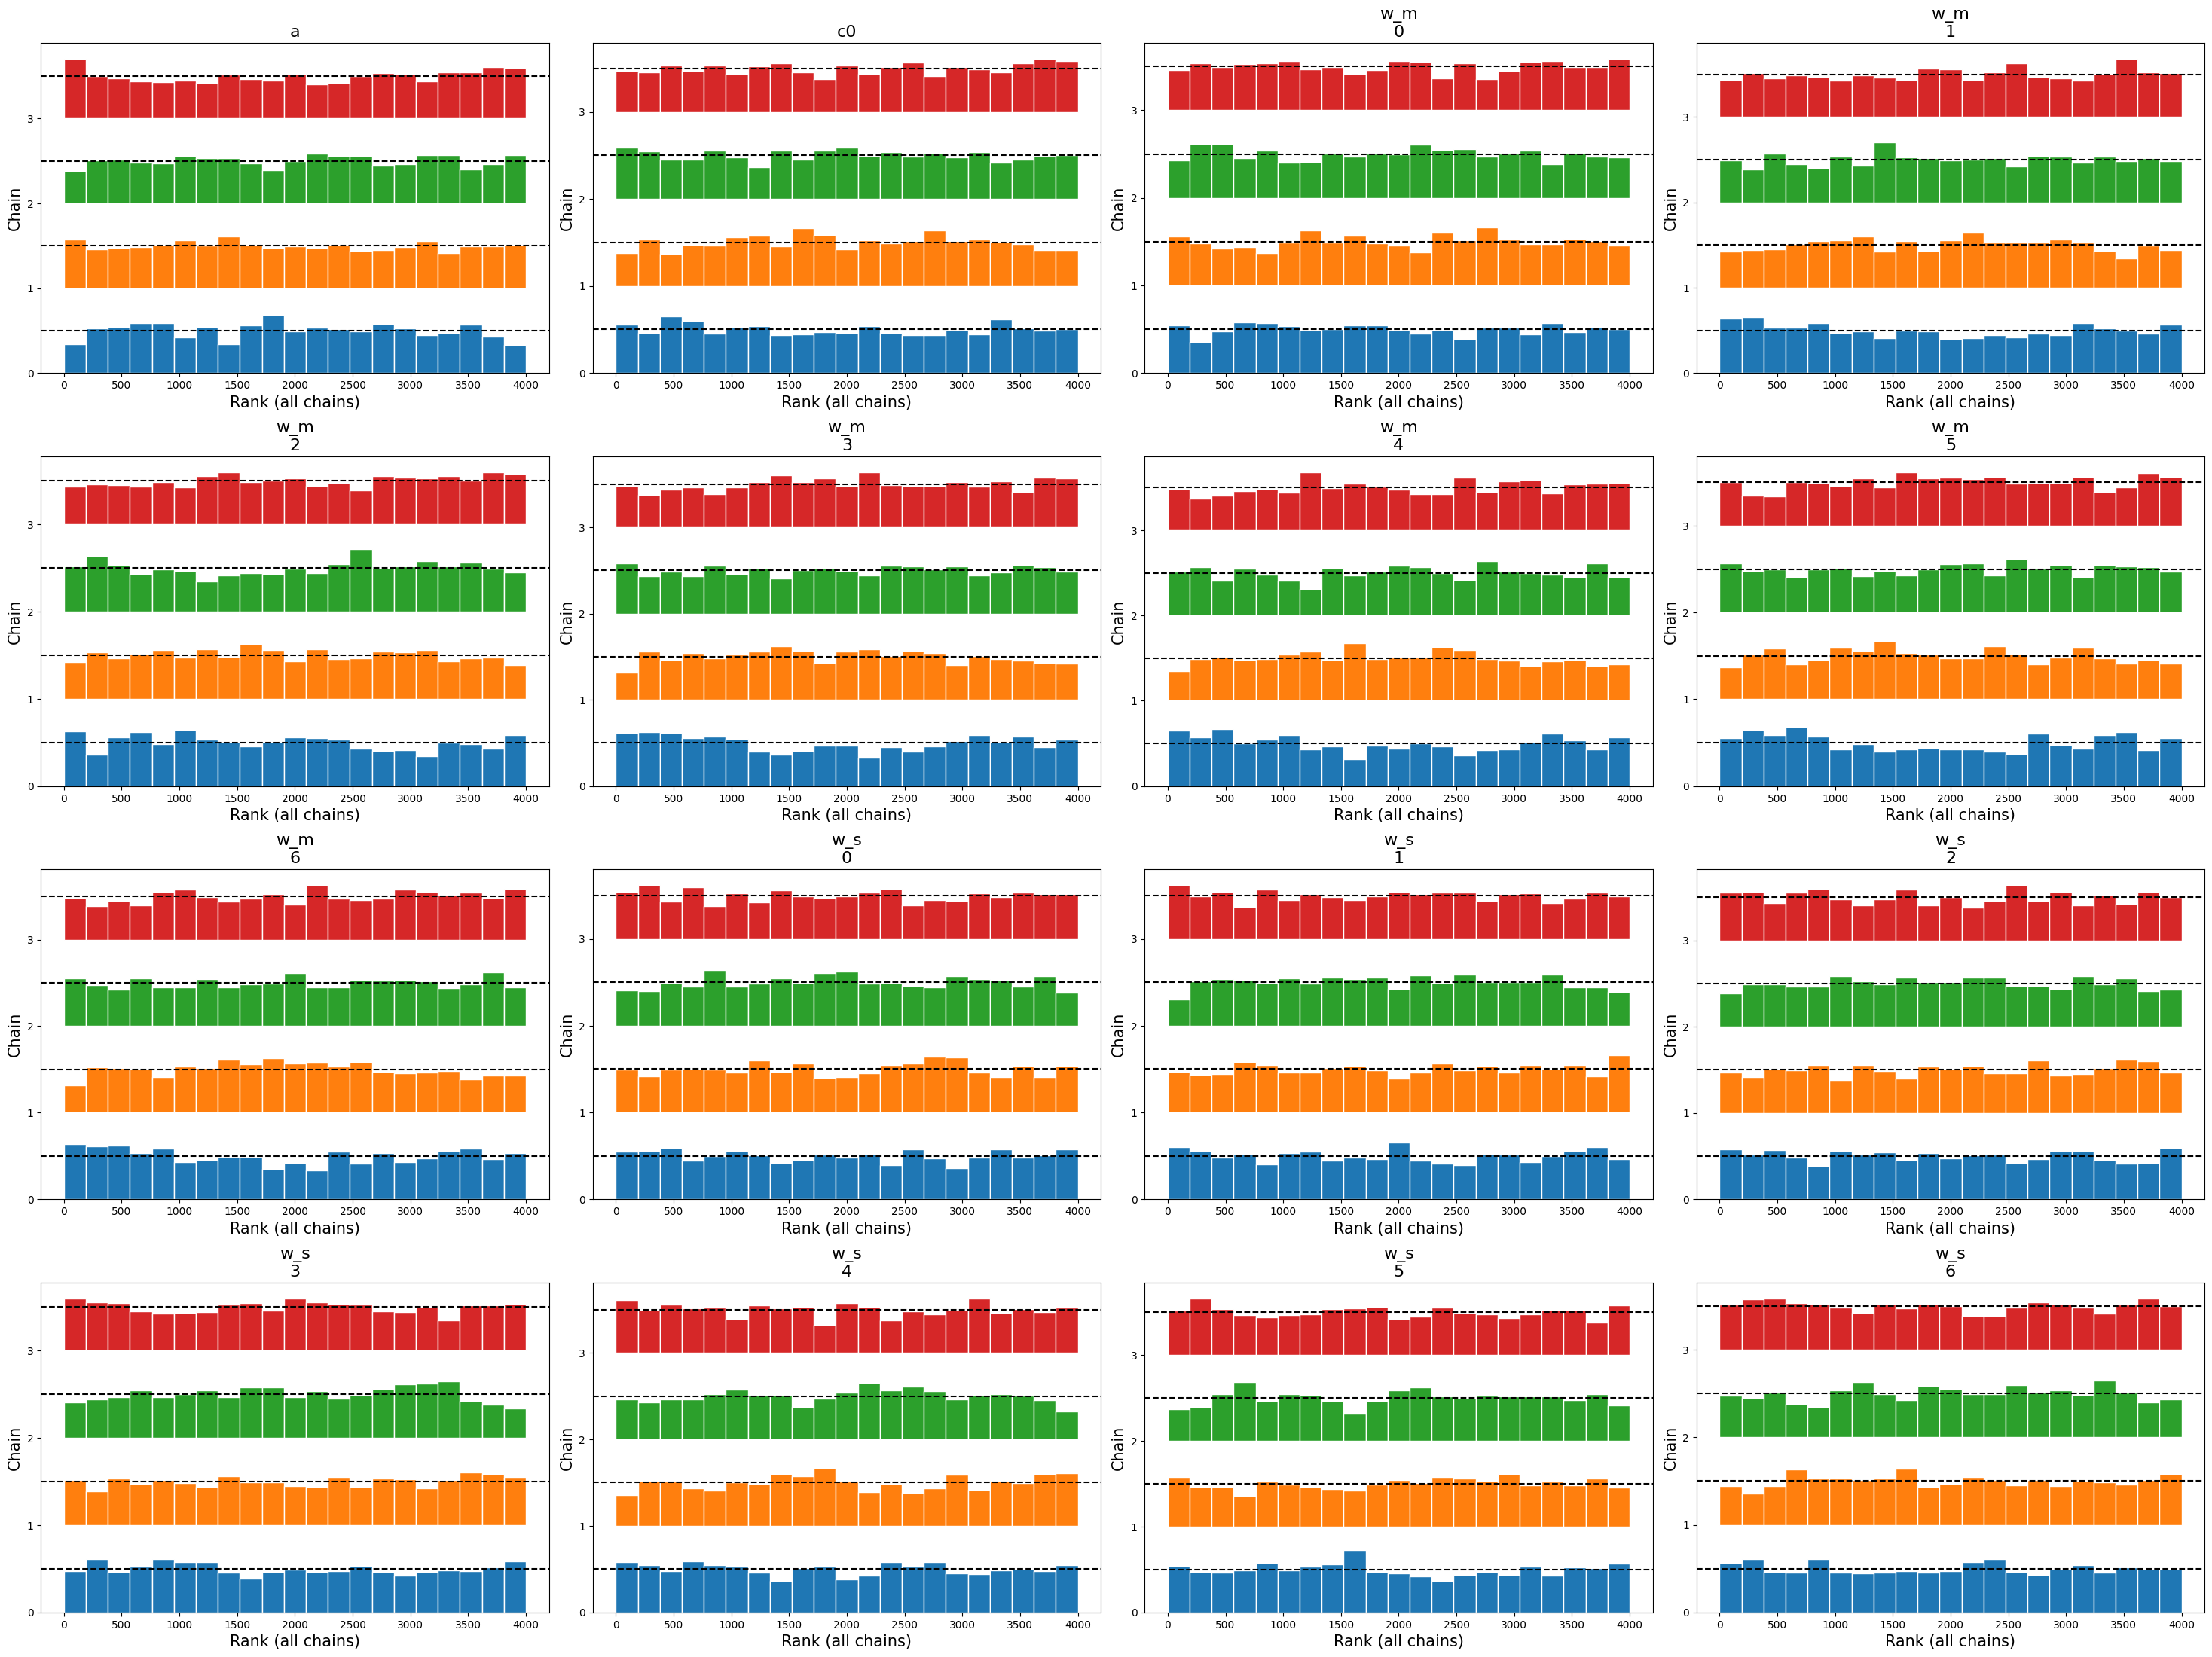

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a      -1.135    0.038   -1.204   -1.062      0.001    0.001    4127.0   
c0      0.602    0.010    0.582    0.620      0.000    0.000    3862.0   
w_m[0]  1.176  101.264 -193.373  188.223      1.509    1.636    4502.0   
w_m[1] -2.376    1.372   -5.117    0.028      0.036    0.027    1446.0   
w_m[2] -0.910    0.781   -2.317    0.644      0.020    0.015    1521.0   
w_m[3]  0.917    0.831   -0.644    2.450      0.023    0.018    1289.0   
w_m[4]  1.367    0.799   -0.225    2.792      0.022    0.018    1268.0   
w_m[5]  0.633    0.826   -0.973    2.121      0.023    0.018    1284.0   
w_m[6]  1.336    0.816   -0.148    2.963      0.022    0.019    1330.0   
w_s[0] -0.011    0.498   -0.938    0.910      0.007    0.008    4682.0   
w_s[1]  0.347    0.235   -0.091    0.777      0.006    0.004    1662.0   
w_s[2]  1.594    0.129    1.356    1.833      0.003    0.002    1764.0   
w_s[3] -0.447    0.146   -0.708   -0.167      0.004    0.002    1559.0   
w_s[4] -0.716    0.139   -0.973   -0.458      0.004    0.002    1520.0   
w_s[5] -1.566    0.184   -1.883   -1.200      0.004    0.003    2004.0   
w_s[6] -1.535    0.226   -1.974   -1.124      0.004    0.003    2715.0   

        ess_tail  r_hat  
a         2595.0    1.0  
c0        2517.0    1.0  
w_m[0]    2797.0    1.0  
w_m[1]    1983.0    1.0  
w_m[2]    2052.0    1.0  
w_m[3]    1764.0    1.0  
w_m[4]    1580.0    1.0  
w_m[5]    1879.0    1.0  
w_m[6]    1698.0    1.0  
w_s[0]    2938.0    1.0  
w_s[1]    2306.0    1.0  
w_s[2]    2560.0    1.0  
w_s[3]    2284.0    1.0  
w_s[4]    2139.0    1.0  
w_s[5]    2677.0    1.0  
w_s[6]    2892.0    1.0

Spline 5 Model


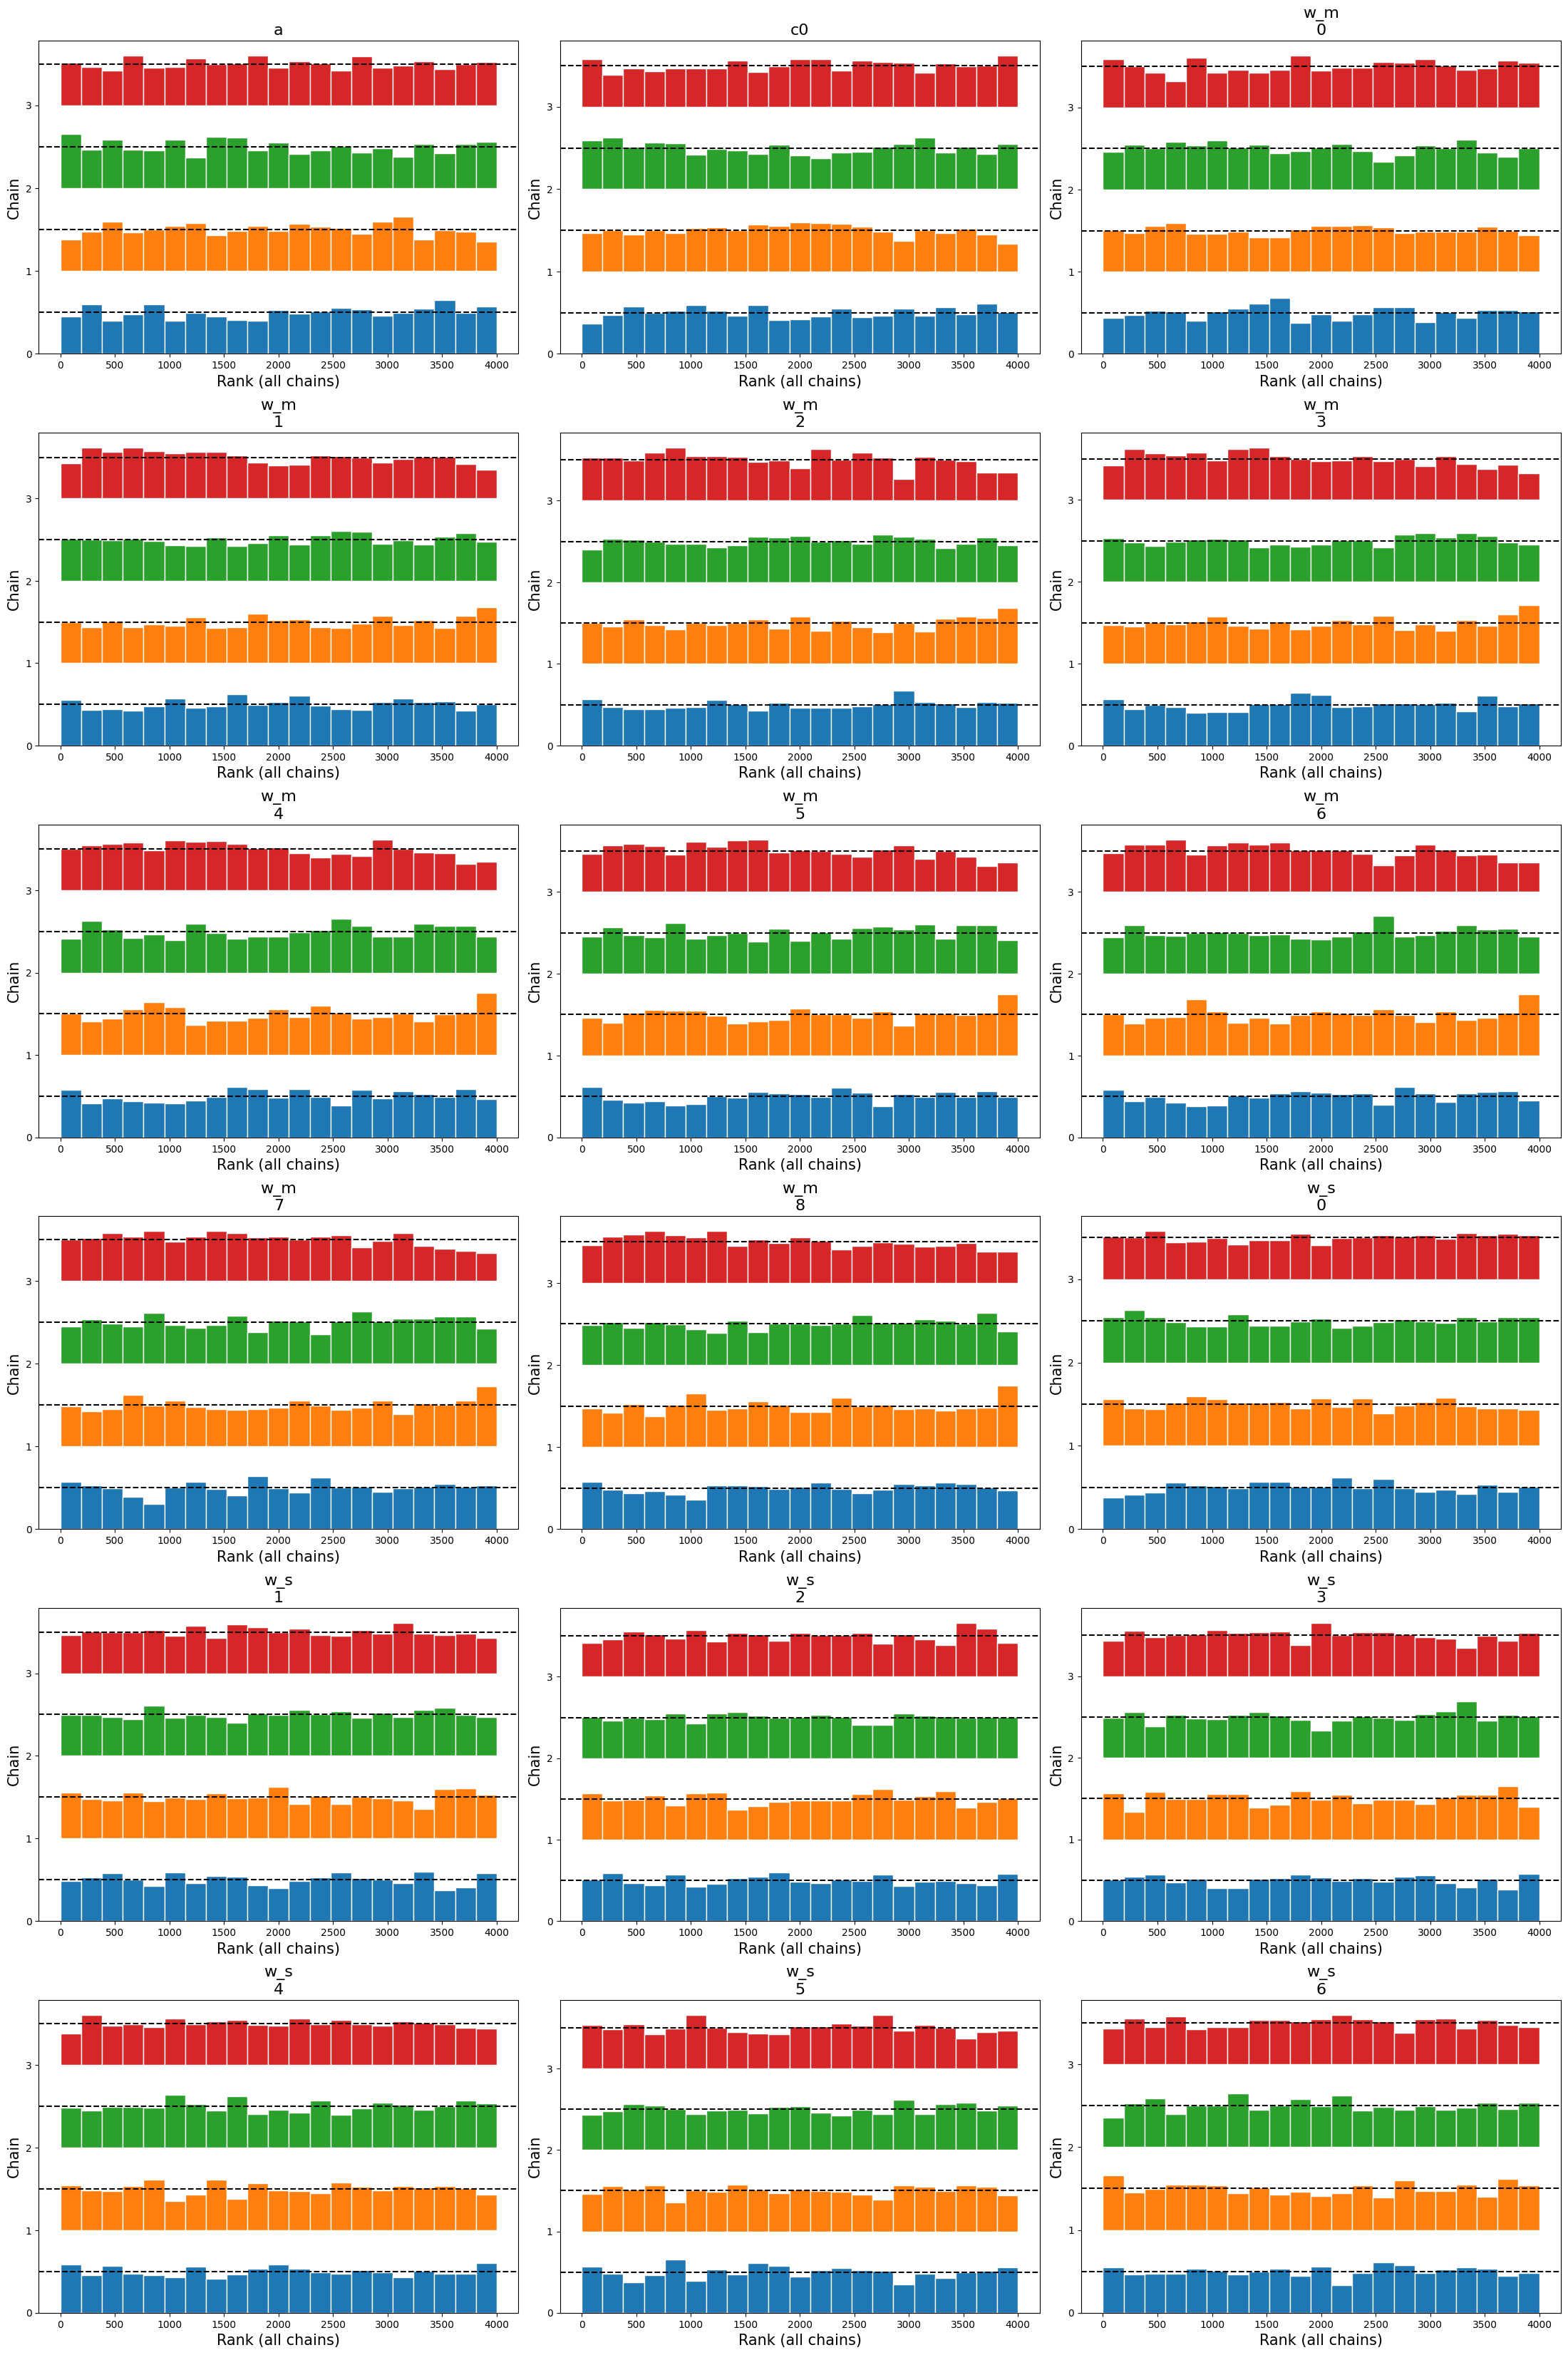

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a      -1.137   0.038   -1.208   -1.065      0.001    0.001    4998.0   
c0      0.602   0.010    0.582    0.620      0.000    0.000    4723.0   
w_m[0] -0.140  98.815 -185.510  181.779      1.414    1.739    4880.0   
w_m[1] -1.723   1.597   -4.761    1.181      0.053    0.030     912.0   
w_m[2] -1.409   0.918   -3.048    0.412      0.027    0.016    1143.0   
w_m[3]  0.495   0.969   -1.388    2.271      0.035    0.021     784.0   
w_m[4]  1.054   0.906   -0.648    2.754      0.033    0.020     749.0   
w_m[5]  1.290   0.915   -0.455    3.000      0.033    0.020     753.0   
w_m[6]  1.240   0.915   -0.529    2.897      0.033    0.020     751.0   
w_m[7]  0.756   0.930   -0.957    2.547      0.034    0.020     769.0   
w_m[8]  1.495   0.935   -0.341    3.174      0.033    0.020     782.0   
w_s[0]  0.001   0.510   -0.921    1.006      0.007    0.009    4854.0   
w_s[1]  0.340   0.235   -0.087    0.776      0.006    0.004    1673.0   
w_s[2]  1.586   0.128    1.354    1.837      0.003    0.002    1743.0   
w_s[3] -0.453   0.145   -0.712   -0.168      0.004    0.002    1493.0   
w_s[4] -0.721   0.138   -0.986   -0.467      0.004    0.002    1470.0   
w_s[5] -1.575   0.181   -1.919   -1.243      0.004    0.003    1994.0   
w_s[6] -1.540   0.230   -1.963   -1.100      0.004    0.004    2831.0   

        ess_tail  r_hat  
a         2610.0   1.00  
c0        2538.0   1.00  
w_m[0]    2733.0   1.00  
w_m[1]    1677.0   1.00  
w_m[2]    1910.0   1.00  
w_m[3]    1288.0   1.00  
w_m[4]    1196.0   1.01  
w_m[5]    1244.0   1.00  
w_m[6]    1083.0   1.01  
w_m[7]    1354.0   1.00  
w_m[8]    1230.0   1.00  
w_s[0]    2917.0   1.00  
w_s[1]    2249.0   1.00  
w_s[2]    2364.0   1.00  
w_s[3]    1992.0   1.00  
w_s[4]    2000.0   1.00  
w_s[5]    2408.0   1.00  
w_s[6]    2319.0   1.00

Spline 7 Model


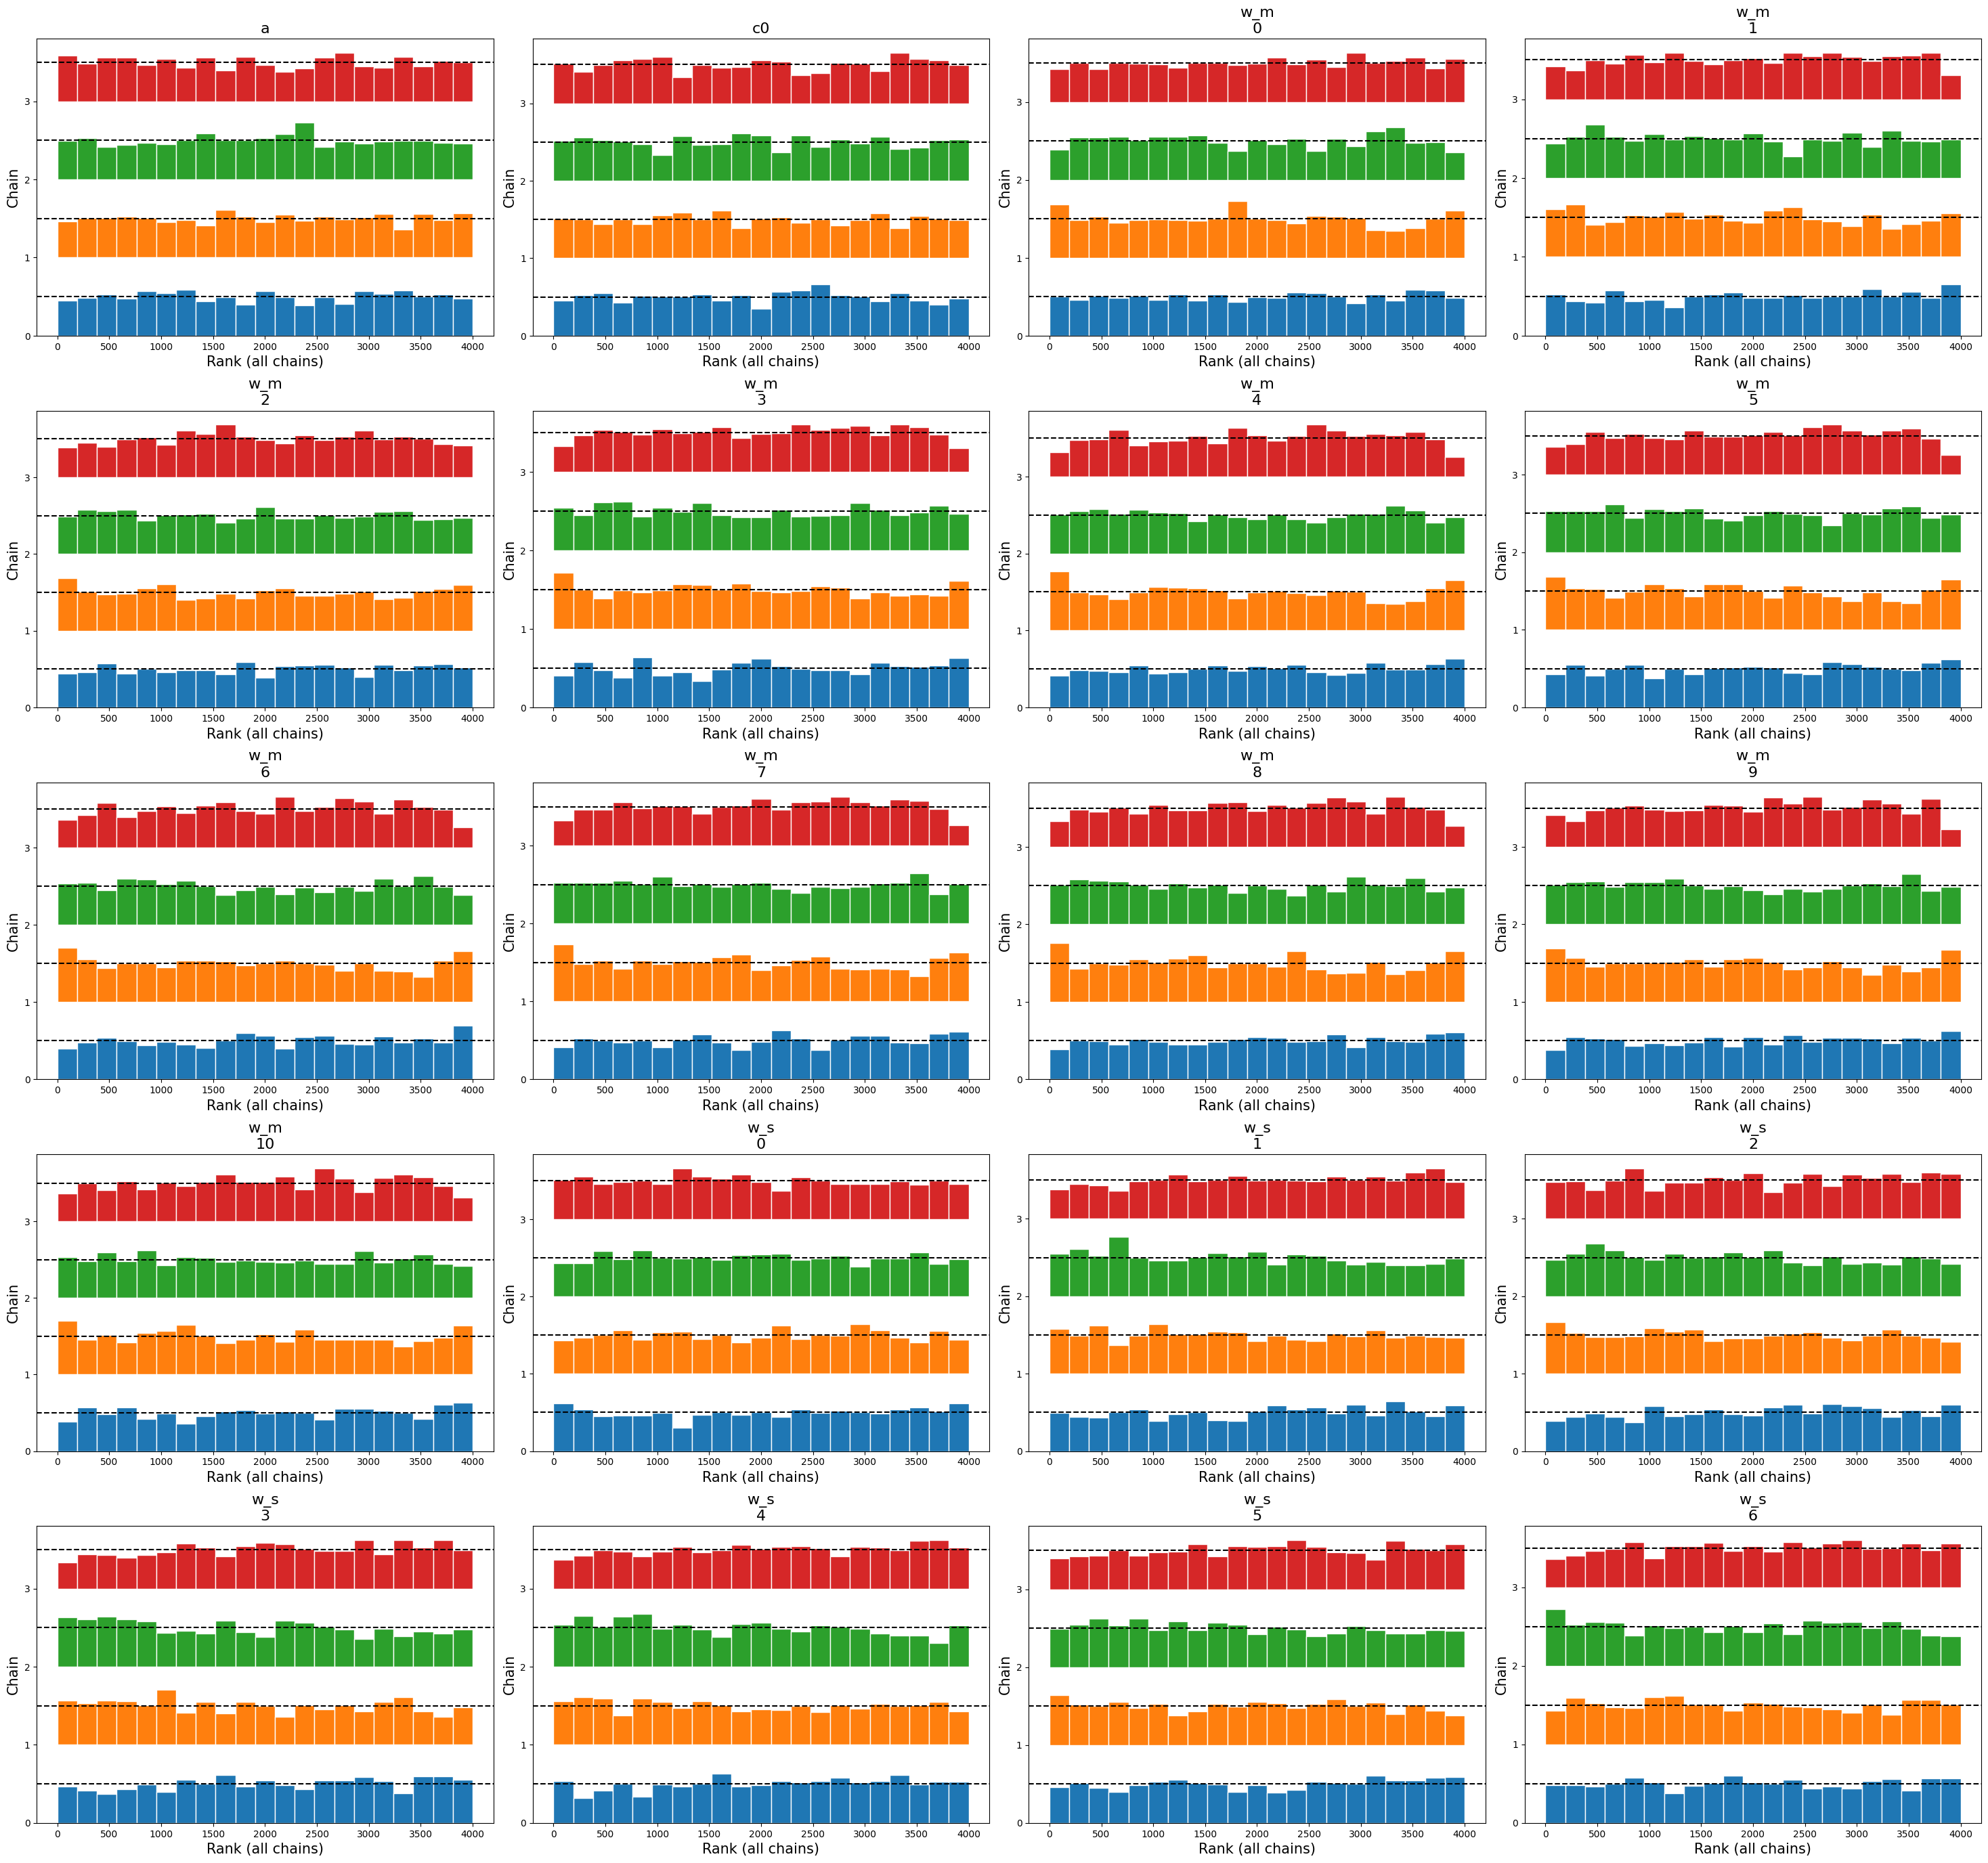

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a       -1.135    0.038   -1.207   -1.065      0.001    0.001    5209.0   
c0       0.601    0.010    0.583    0.620      0.000    0.000    5403.0   
w_m[0]  -0.904  101.062 -186.026  192.431      1.294    1.856    6101.0   
w_m[1]  -1.822    1.807   -5.120    1.604      0.061    0.040     865.0   
w_m[2]  -1.479    1.017   -3.239    0.575      0.030    0.017    1171.0   
w_m[3]  -0.195    1.114   -2.246    1.933      0.041    0.027     757.0   
w_m[4]   0.711    1.024   -1.179    2.673      0.037    0.026     756.0   
w_m[5]   0.798    1.038   -1.169    2.702      0.038    0.026     727.0   
w_m[6]   1.321    1.024   -0.656    3.198      0.038    0.026     731.0   
w_m[7]   1.002    1.025   -0.959    2.872      0.038    0.026     730.0   
w_m[8]   1.294    1.028   -0.723    3.171      0.038    0.026     733.0   
w_m[9]   0.375    1.042   -1.627    2.290      0.038    0.026     758.0   
w_m[10]  1.633    1.049   -0.337    3.626      0.039    0.026     737.0   
w_s[0]   0.001    0.500   -0.920    0.997      0.007    0.010    5480.0   
w_s[1]   0.326    0.234   -0.133    0.740      0.006    0.003    1432.0   
w_s[2]   1.578    0.131    1.344    1.836      0.003    0.002    1574.0   
w_s[3]  -0.460    0.146   -0.742   -0.203      0.004    0.002    1263.0   
w_s[4]  -0.734    0.140   -0.992   -0.461      0.004    0.002    1378.0   
w_s[5]  -1.579    0.178   -1.919   -1.253      0.005    0.002    1534.0   
w_s[6]  -1.551    0.223   -1.982   -1.129      0.004    0.003    2497.0   

         ess_tail  r_hat  
a          2346.0   1.00  
c0         3038.0   1.00  
w_m[0]     2410.0   1.00  
w_m[1]     1401.0   1.00  
w_m[2]     1905.0   1.00  
w_m[3]     1109.0   1.00  
w_m[4]      977.0   1.00  
w_m[5]     1067.0   1.00  
w_m[6]      926.0   1.00  
w_m[7]      967.0   1.00  
w_m[8]      983.0   1.00  
w_m[9]     1086.0   1.00  
w_m[10]    1164.0   1.00  
w_s[0]     2842.0   1.00  
w_s[1]     2347.0   1.01  
w_s[2]     2341.0   1.01  
w_s[3]     2213.0   1.01  
w_s[4]     2301.0   1.01  
w_s[5]     2726.0   1.00  
w_s[6]     2616.0   1.00

In [28]:
# Rank plots and summaries of spline models
for k in (3, 5, 7):
    print(f"Spline {k} Model")
    post_rank_plot(globals()[f"post_spline_{k}"], var_names=["a", "c0", "w_m", "w_s"])
    post_samp_sum(globals()[f"post_spline_{k}"], var_names=["a", "c0", "w_m", "w_s"])

The posterior diagnostics for all spline models indicate stable and efficient sampling.

The rank plots are uniform, and all parameter `r_hat` values are 1.00 or 1.01, confirming full chain convergence. Both `ess_bulk` and `ess_tail` are above the 400 threshold, showing good effective sample sizes across all parameters.

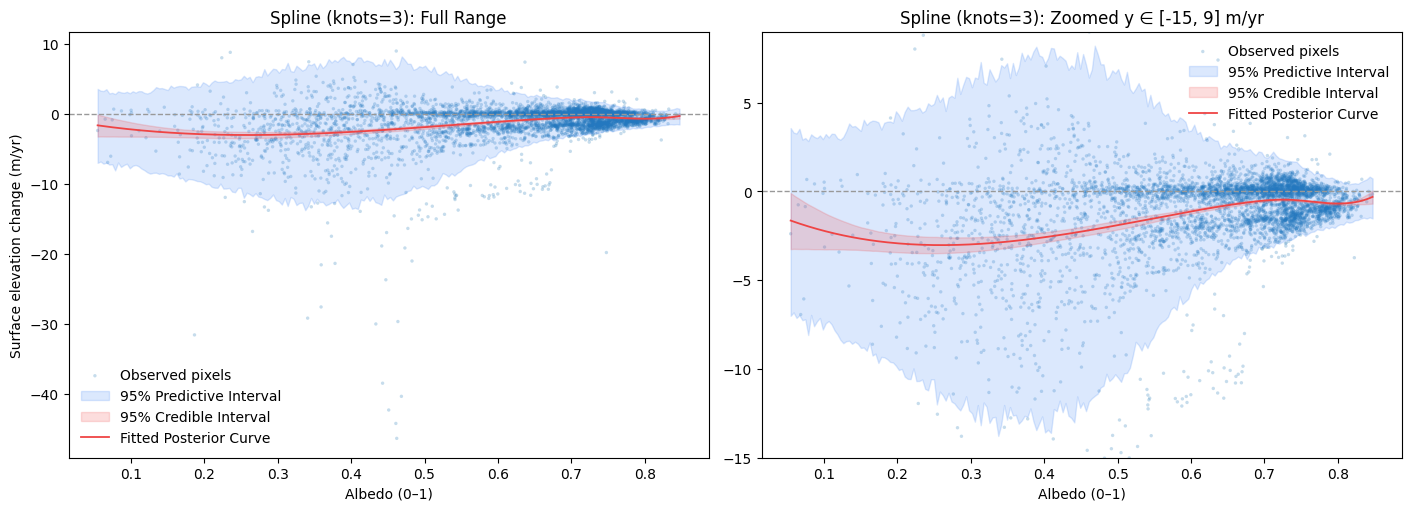

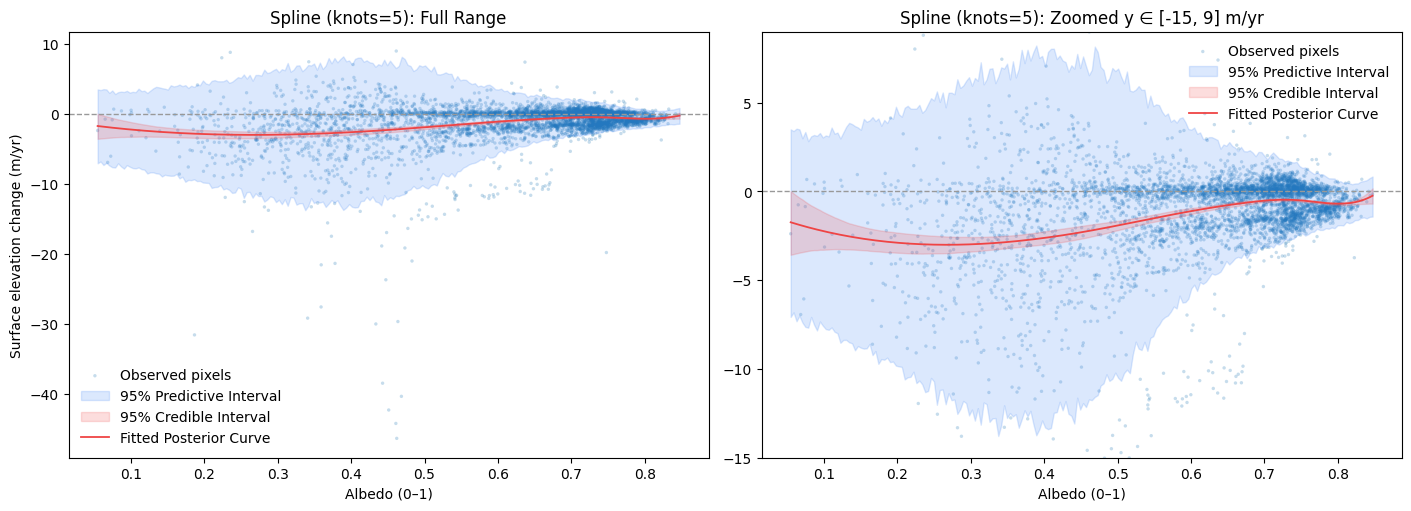

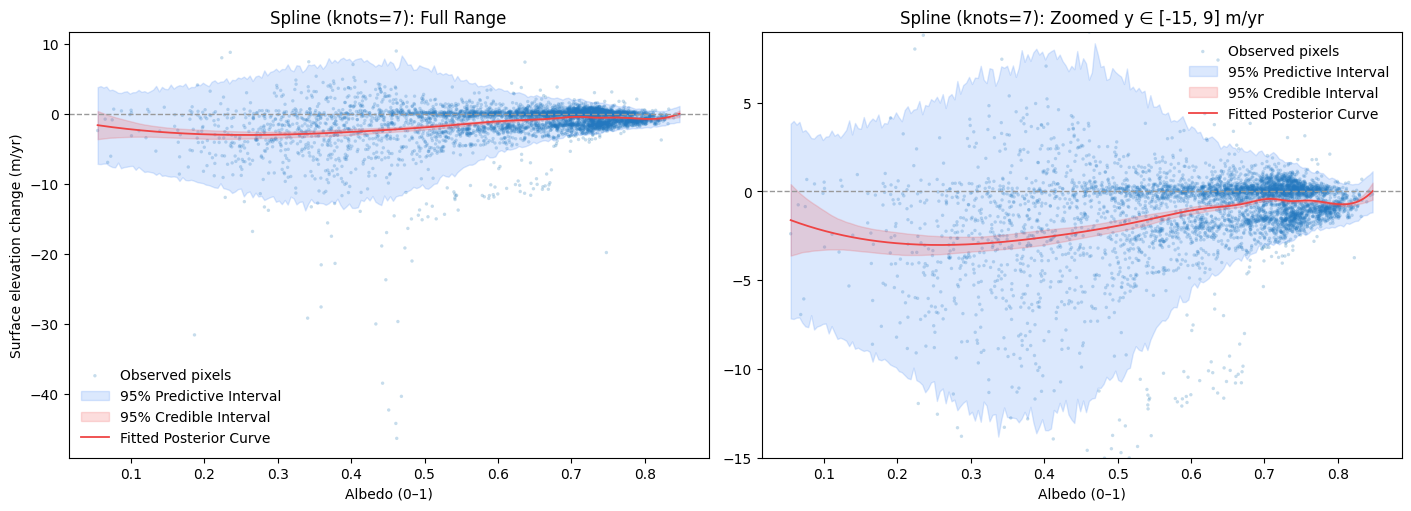

In [29]:
# Plot posterior predictive of spline models with the credible and predictive intervals
for k in (3, 5, 7):
    # Rebuild centered B-spline bases for this k
    Bm, Bm_g = centered_bs(X, XG, num_knots=k)
    Bs, Bs_g = centered_bs(X, XG, num_knots=3)

    idata = globals()[f"post_pred_spline_{k}"]

    # Calculate mean for for the X grid
    def mu_post_grid_spline(idata, xg, group="posterior", Bm_g=Bm_g):
        a = idata[group]["a"].stack(sample=("chain","draw")).values[:, None]

        wm_da = idata[group]["w_m"].stack(sample=("chain","draw"))
        kdim = [d for d in wm_da.dims if d not in ("chain", "draw", "sample")][0]
        wm = wm_da.transpose("sample", kdim).values
        return a + wm @ Bm_g.T

    # Calculate sigma for for the X grid
    def sigma_post_grid_spline(idata, xg, group="posterior", Bs_g=Bs_g):
        c0 = idata[group]["c0"].stack(sample=("chain","draw")).values[:, None]

        ws_da = idata[group]["w_s"].stack(sample=("chain","draw"))
        kdim = [d for d in ws_da.dims if d not in ("chain", "draw", "sample")][0]
        ws = ws_da.transpose("sample", kdim).values
        return np.exp(c0 + ws @ Bs_g.T)

    # Visualize
    viz_post_fit_2panel(
        inf_data=idata,
        mu_grid_fn=mu_post_grid_spline,
        sigma_grid_fn=sigma_post_grid_spline,
        x=X, y=Y, xg=XG,
        zoom_ylim=(-15, 9),
        label_prefix=f"Spline (knots={k})"
    )

The posterior predictive plots for the spline models show how increasing the number of knots progressively improves the model’s ability to capture nonlinearities in the relationship between albedo and elevation change.

With only 3 knots, the fitted curve remains relatively smooth, similar to the heteroscedastic linear model, but already begins to adapt more flexibly to regions where the data deviate from a straight line. As the number of knots increases to 5 and 7, the fit becomes more sensitive to the curvature in the data, especially around medium albedo values.

The predictive intervals also adapt well to uncertainty in the data, widening in areas with higher data variability and narrowing where the relationship is more stable. This reflects the model’s heteroscedastic and nonlinear nature: variance is not constant, and the mean relationship adjusts across the albedo range.

While adding knots improves flexibility, it also increases the risk of overfitting, so it’s important to compare these models quantitatively.

## Model Comparison

After fitting all models, I compare their out-of-sample predictive performance using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO). This method estimates how well each model is expected to generalize to unseen data by systematically leaving out one observation at a time and evaluating how likely the model would have predicted it.

In the code cell below, I first collect the inference data from each fitted model into a dictionary called `model_dict`. Each entry includes posterior and posterior predictive draws for a specific model (linear, heteroscedastic linear, and splines with different knot counts).

The function `az.compare(model_dict, ic="loo")` from the `arviz` library then computes the PSIS-LOO information criterion for all models and ranks them based on their expected log predictive density (ELPD); a higher ELPD indicates better out-of-sample predictive performance.

In [30]:
# Collect all model inference data
model_dict = {
    "Linear": post_pred_linear,
    "Heteroscedastic Linear": post_pred_het_linear,
    "3-knot Spline": globals()["post_pred_spline_3"],
    "5-knot Spline": globals()["post_pred_spline_5"],
    "7-knot Spline": globals()["post_pred_spline_7"],
}

# Compute PSIS-LOO for all models
model_comparison = az.compare(model_dict, ic="loo")

# Display results
display(model_comparison)

/Users/rolandsbarkans/Desktop/minerva/course assignments/CS146/CS146 Assignment 2/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/rolandsbarkans/Desktop/minerva/course assignments/CS146/CS146 Assignment 2/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non

rank      elpd_loo      p_loo    elpd_diff  \
7-knot Spline              0 -10146.573378  81.876392     0.000000   
3-knot Spline              1 -10146.990905  79.067723     0.417526   
5-knot Spline              2 -10149.347703  84.639367     2.774325   
Heteroscedastic Linear     3 -10422.979639  37.120341   276.406260   
Linear                     4 -12193.896838  35.255270  2047.323460   

                              weight          se         dse  warning scale  
7-knot Spline           4.288960e-14  237.896644    0.000000     True   log  
3-knot Spline           9.382037e-01  238.410754    2.339148     True   log  
5-knot Spline           4.601185e-14  239.918311    3.255950     True   log  
Heteroscedastic Linear  3.367938e-02  228.974360   66.917759     True   log  
Linear                  2.811695e-02  286.144334  260.776295     True   log

Notice that all models include a `warning=True` flag, which typically arises from minor PSIS diagnostic issues (e.g., high Pareto k values). This is acceptable here, since the relative model ranking remains stable.

Let's also visualize the comparison between models' PSIS-LOO results on a plot.

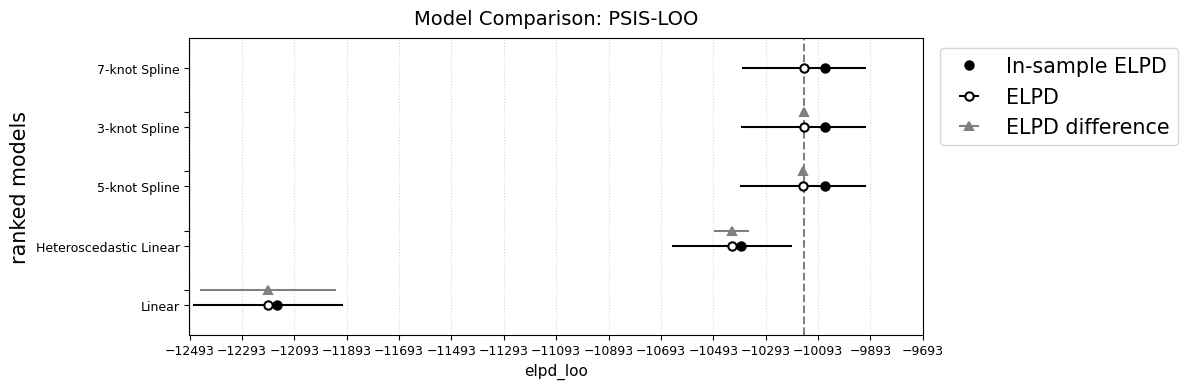

In [31]:
# PSIS-LOO visualization of all models
fig, ax = plt.subplots(figsize=(12, 4))

az.plot_compare(
    model_comparison,
    insample_dev=True,
    plot_ic_diff=True,
    legend=True,
    ax=ax
)

ax.set_title("Model Comparison: PSIS-LOO", fontsize=14, pad=10)
ax.set_xlabel("elpd_loo", fontsize=11)
ax.grid(True, axis='x', linestyle=':', alpha=0.5)

elpd_vals = model_comparison["elpd_loo"].values
lo, hi = elpd_vals.min(), elpd_vals.max()

pad = 300
ax.set_xlim(lo - pad, hi)

tick_step = 200
xticks = np.arange(int(lo - pad), int(hi + pad) + tick_step, tick_step)
ax.set_xticks(xticks)

ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

The PSIS-LOO table and visualization together show that the B-spline models outperform the linear ones in predictive accuracy. Among them, the 7-knot spline ranks highest with the largest expected log predictive density (ELPD), meaning it best generalizes to unseen data. However, its improvement over the 3-knot spline is minimal (ΔELPD ≈ 0.28), suggesting that adding more knots only slightly improves fit while increasing complexity. The 5-knot spline performs similarly well, indicating that all spline-based models capture the nonlinear relationship between albedo and elevation change far better than either linear alternative.

The linear and heteroscedastic linear models, plotted toward the far left, have considerably lower ELPD values, confirming that their simpler functional forms cannot explain the observed variability in the data. The small gray triangles (ELPD differences) and horizontal uncertainty bars show that these performance gaps are meaningful and not due to sampling noise.

Let's zoom in the PSIS-LOO plot more to see whether there are any significant differences among the spline models.

In [32]:
# Remove warnings
warnings.filterwarnings("ignore", message="Estimated shape parameter")

# Collect all spline model inference data
spline_model_dict = {
    "3-knot Spline": globals()["post_pred_spline_3"],
    "5-knot Spline": globals()["post_pred_spline_5"],
    "7-knot Spline": globals()["post_pred_spline_7"]
}

# Compute PSIS-LOO for spline models
spline_model_comparison = az.compare(spline_model_dict, ic="loo")

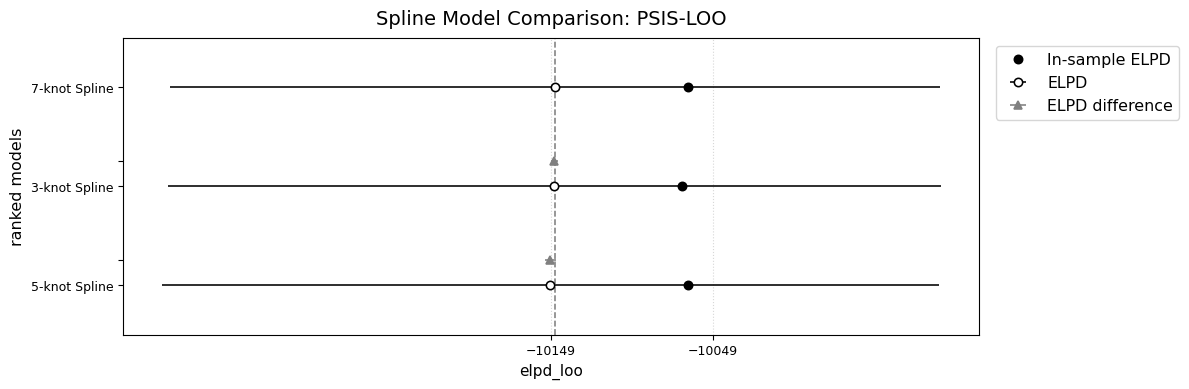

In [33]:
# PSIS-LOO visualization of spline models
fig, ax = plt.subplots(figsize=(12, 4))

az.plot_compare(
    spline_model_comparison,
    insample_dev=True,
    plot_ic_diff=True,
    legend=True,
    ax=ax
)

ax.set_title("Spline Model Comparison: PSIS-LOO", fontsize=14, pad=10)
ax.set_xlabel("elpd_loo", fontsize=11)
ax.grid(True, axis='x', linestyle=':', alpha=0.5)

elpd_vals = spline_model_comparison["elpd_loo"].values
lo, hi = elpd_vals.min(), elpd_vals.max()

pad = 500
#ax.set_xlim(lo - pad, hi)

tick_step = 100
xticks = np.arange(int(lo), int(hi) + tick_step, tick_step)
ax.set_xticks(xticks)

ax.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

When focusing only on the spline models, the 7-knot spline remains the top performer. The ELPD difference intervals in the PSIS-LOO plot show that the 5-knot spline’s gray uncertainty bar does not cross the dashed reference line, meaning its predictive performance is statistically distinguishable from the 7-knot model. In contrast, the 3-knot spline’s interval overlaps the dashed line, indicating that its performance is statistically indistinguishable from the 7-knot spline; it achieves almost the same predictive accuracy while being simpler. This suggests that while the 7-knot model captures extreme nonlinearities, the 3-knot version generalizes just as well with fewer parameters.

## Conclusion

This project looked at how surface reflectivity (albedo) relates to changes in glacier elevation across the Southern Patagonian Icefield between 2000 and 2015.
I started with a basic linear model to get a feel for the trend, then moved to a heteroscedastic model to let the variance change with albedo, and finally to B-spline models that can bend to capture nonlinear relationships in the data.

By comparing models using PSIS-LOO cross-validation, the spline models do a much better job of describing what’s happening in the icefield than either of the linear ones. The 7-knot spline gives the best overall fit, but the 3-knot spline performs nearly as well and stays simpler and cleaner, a nice balance between flexibility and generalization.

Overall, the results show that as albedo increases, glaciers tend to thin more slowly. That pattern lines up with what I learned in my Earth’s Cycles class; brighter, more reflective ice absorbs less heat, which helps slow down melting.

# References

Malz, P., Meier, W. J.-H., Casassa, G., Jaña, R., Skvarca, P., & Braun, M. H. (2018). Annual glacier elevation change rate raster dataset, Southern Patagonia Ice Field, 2000 and 2015 (unfiltered). https://doi.org/10.1594/pangaea.896756
